<a href="https://colab.research.google.com/github/JacekPardyak/tb-data-science-talks/blob/master/2022-06-30/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Dutch restaurants locations

In [1]:
library(tidyverse)
# data source https://www.theanalyticslab.nl/nlpblogs_0_preparing_restaurant_review_data_for_nlp_and_predictive_modeling/
# the encoding issue has been fixed.
system("wget --continue https://github.com/JacekPardyak/tb-data-science-talks/raw/master/2022-06-09/reviews.csv.gz -O /tmp/reviews.csv.gz")
reviews <- read_csv("/tmp/reviews.csv.gz")
str(reviews)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Rows: 339524 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (8): restoName, tags, address, valueForPriceScore, noiseLevelScore, wa...
dbl  (15): restoId, scoreTotal, avgPrice, numReviews, scoreFood, scoreServic...
dttm  (1): reviewDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


spec_tbl_df [339,524 × 24] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ restoId            : num [1:339524] 255757 255757 255757 255757 255757 ...
 $ restoName          : chr [1:339524] "India Palace" "India Palace" "India Palace" "India Palace" ...
 $ tags               : chr [1:339524] "Indiaas|zakenlunch|Live muziek|Met familie|Met vrienden|provincie Zuid-Holland|Terras|Tuin" "Indiaas|zakenlunch|Live muziek|Met familie|Met vrienden|provincie Zuid-Holland|Terras|Tuin" "Indiaas|zakenlunch|Live muziek|Met familie|Met vrienden|provincie Zuid-Holland|Terras|Tuin" "Indiaas|zakenlunch|Live muziek|Met familie|Met vrienden|provincie Zuid-Holland|Terras|Tuin" ...
 $ address            : chr [1:339524] "Natuursteenlaan 157 2719 TB Zoetermeer Nederland" "Natuursteenlaan 157 2719 TB Zoetermeer Nederland" "Natuursteenlaan 157 2719 TB Zoetermeer Nederland" "Natuursteenlaan 157 2719 TB Zoetermeer Nederland" ...
 $ scoreTotal         : num [1:339524] 8 8 8 8 8 8 8 8 8 8 ...
 $ avgPrice           : num

# Get restaurant locations

In [2]:
locations <- reviews %>%
  select("restoId", "restoName", "address") %>% unique()  %>%
  extract(col = address, into=c('postcode'), regex = "(\\d{4}\\s+[A-Z]{2})", remove = FALSE) %>%
  mutate(postcode = gsub(" ", "", postcode)) %>% 
  filter(!is.na(postcode)) # drop 7 percent not fitting the mask

locations %>% head()

restoId,restoName,address,postcode
<dbl>,<chr>,<chr>,<chr>
255757,India Palace,Natuursteenlaan 157 2719 TB Zoetermeer Nederland,2719TB
236127,Mother India,Ter Haarstraat 14 1053 LJ Amsterdam Nederland,1053LJ
246631,Italiaanse IJssalon Capriccio,Strandweg 71 2586 JL Den Haag Nederland,2586JL
326635,Winehouse Somm,Baffinstraat 1 1057 SV Amsterdam Nederland,1057SV
427377,De Herberg van Anderen,Nijend 2 9465 TR Anderen Nederland,9465TR
243427,Omonia,Haarlemmerstraat 244 2312 GK Leiden Nederland,2312GK


# Show locations on the map

In [3]:
# install sf
system("sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable")
system("sudo apt-get update")
system("sudo apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev")
install.packages('sf')
library(sf)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 7.0.0; sf_use_s2() is TRUE



In [4]:
# install geojsonio
system("sudo apt-get install libgdal1-dev libgdal-dev libgeos-c1 libproj-dev")
system("sudo apt-get install -y libprotobuf-dev protobuf-compiler")
system("sudo apt-get install -y libjq-dev")
install.packages("rgeos")
install.packages("protolite")
install.packages("jqr")
install.packages("geojsonio")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
# Retrieve data with municipal boundaries from PDOK
municipalBoundaries <- st_read("https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json")

Reading layer `OGRGeoJSON' from data source 
  `https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json' 
  using driver `GeoJSON'
Simple feature collection with 388 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 13565.4 ymin: 306846.9 xmax: 277992.8 ymax: 619291
Projected CRS: Amersfoort / RD New


In [6]:
# get lon - lat data from free service
locations <- locations %>% slice(1:10) # slice to speed up the presentation

library(jsonlite)
result <- tibble()
postcodes <- locations %>% select(postcode) %>% pull() %>% unique()
length(postcodes)

for (code in postcodes) {
  query <- sprintf("type:postcode+AND+postcode:/.*%s.*/", code)
  txt <- sprintf("http://geodata.nationaalgeoregister.nl/locatieserver/free?fq=%s&start=0&rows=1", query)
  response <- fromJSON(txt) %>% .[['response']] %>% .[['docs']]
  if(class(response) == "data.frame"){
    response <- response %>% select(centroide_rd, postcode)
    } else {
    response <- tibble()
  }
  result <- result %>% bind_rows(response)
}

locations <- locations %>% left_join(result) %>% 
  filter(!is.na(centroide_rd)) %>% # drop 41 postcodes not existing
  st_as_sf(wkt = "centroide_rd") %>% st_set_crs(st_crs(municipalBoundaries))

locations
st_write(obj = locations, dsn = "/tmp/restaurants.geojson", append=FALSE)


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




[1] 10

Joining, by = "postcode"
Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,restoId,restoName,address,postcode,centroide_rd
,<dbl>,<chr>,<chr>,<chr>,<POINT [m]>
1,255757,India Palace,Natuursteenlaan 157 2719 TB Zoetermeer Nederland,2719TB,POINT (93005.54 449961.8)
2,236127,Mother India,Ter Haarstraat 14 1053 LJ Amsterdam Nederland,1053LJ,POINT (119748.6 487054.3)
3,246631,Italiaanse IJssalon Capriccio,Strandweg 71 2586 JL Den Haag Nederland,2586JL,POINT (79361.37 459065.1)
4,326635,Winehouse Somm,Baffinstraat 1 1057 SV Amsterdam Nederland,1057SV,POINT (118706.4 486882.5)
5,427377,De Herberg van Anderen,Nijend 2 9465 TR Anderen Nederland,9465TR,POINT (242064.1 557369.6)
6,243427,Omonia,Haarlemmerstraat 244 2312 GK Leiden Nederland,2312GK,POINT (94126.95 464004.1)
7,235501,Oortjeshekken,Erlecomsedam 4 6576 JW Ooij Nederland,6576JW,POINT (192888.1 430586.6)
8,229435,Bamboo-Inn,Oude Provincialeweg 23 5527 BM Hapert Nederland,5527BM,POINT (145662 375745.5)
9,233617,Amrath Hotel Brabant Brabant,Heerbaan 4 4817 NL Breda Nederland,4817NL,POINT (115292.5 399656.1)


Warning message in CPL_write_ogr(obj, dsn, layer, driver, as.character(dataset_options), :
“GDAL Error 6: DeleteLayer() not supported by this dataset.”


Deleting layer not supported by driver `GeoJSON'
Deleting layer `restaurants' failed
Writing layer `restaurants' to data source 
  `/tmp/restaurants.geojson' using driver `GeoJSON'
Updating existing layer restaurants
Writing 10 features with 4 fields and geometry type Point.


In [7]:
locations <- st_read("https://github.com/JacekPardyak/tb-data-science-talks/raw/master/2022-06-30/restaurants.geojson")
locations %>% head()

Reading layer `restaurants' from data source 
  `https://github.com/JacekPardyak/tb-data-science-talks/raw/master/2022-06-30/restaurants.geojson' 
  using driver `GeoJSON'
Simple feature collection with 11363 features and 4 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 14002.76 ymin: 308479 xmax: 276424 ymax: 612370.1
Projected CRS: Amersfoort / RD New


,restoId,restoName,address,postcode,geometry
,<dbl>,<chr>,<chr>,<chr>,<POINT [m]>
1,255757,India Palace,Natuursteenlaan 157 2719 TB Zoetermeer Nederland,2719TB,POINT (93005.54 449961.8)
2,236127,Mother India,Ter Haarstraat 14 1053 LJ Amsterdam Nederland,1053LJ,POINT (119748.6 487054.3)
3,246631,Italiaanse IJssalon Capriccio,Strandweg 71 2586 JL Den Haag Nederland,2586JL,POINT (79361.37 459065.1)
4,326635,Winehouse Somm,Baffinstraat 1 1057 SV Amsterdam Nederland,1057SV,POINT (118706.4 486882.5)
5,427377,De Herberg van Anderen,Nijend 2 9465 TR Anderen Nederland,9465TR,POINT (242064.1 557369.6)
6,243427,Omonia,Haarlemmerstraat 244 2312 GK Leiden Nederland,2312GK,POINT (94126.95 464004.1)


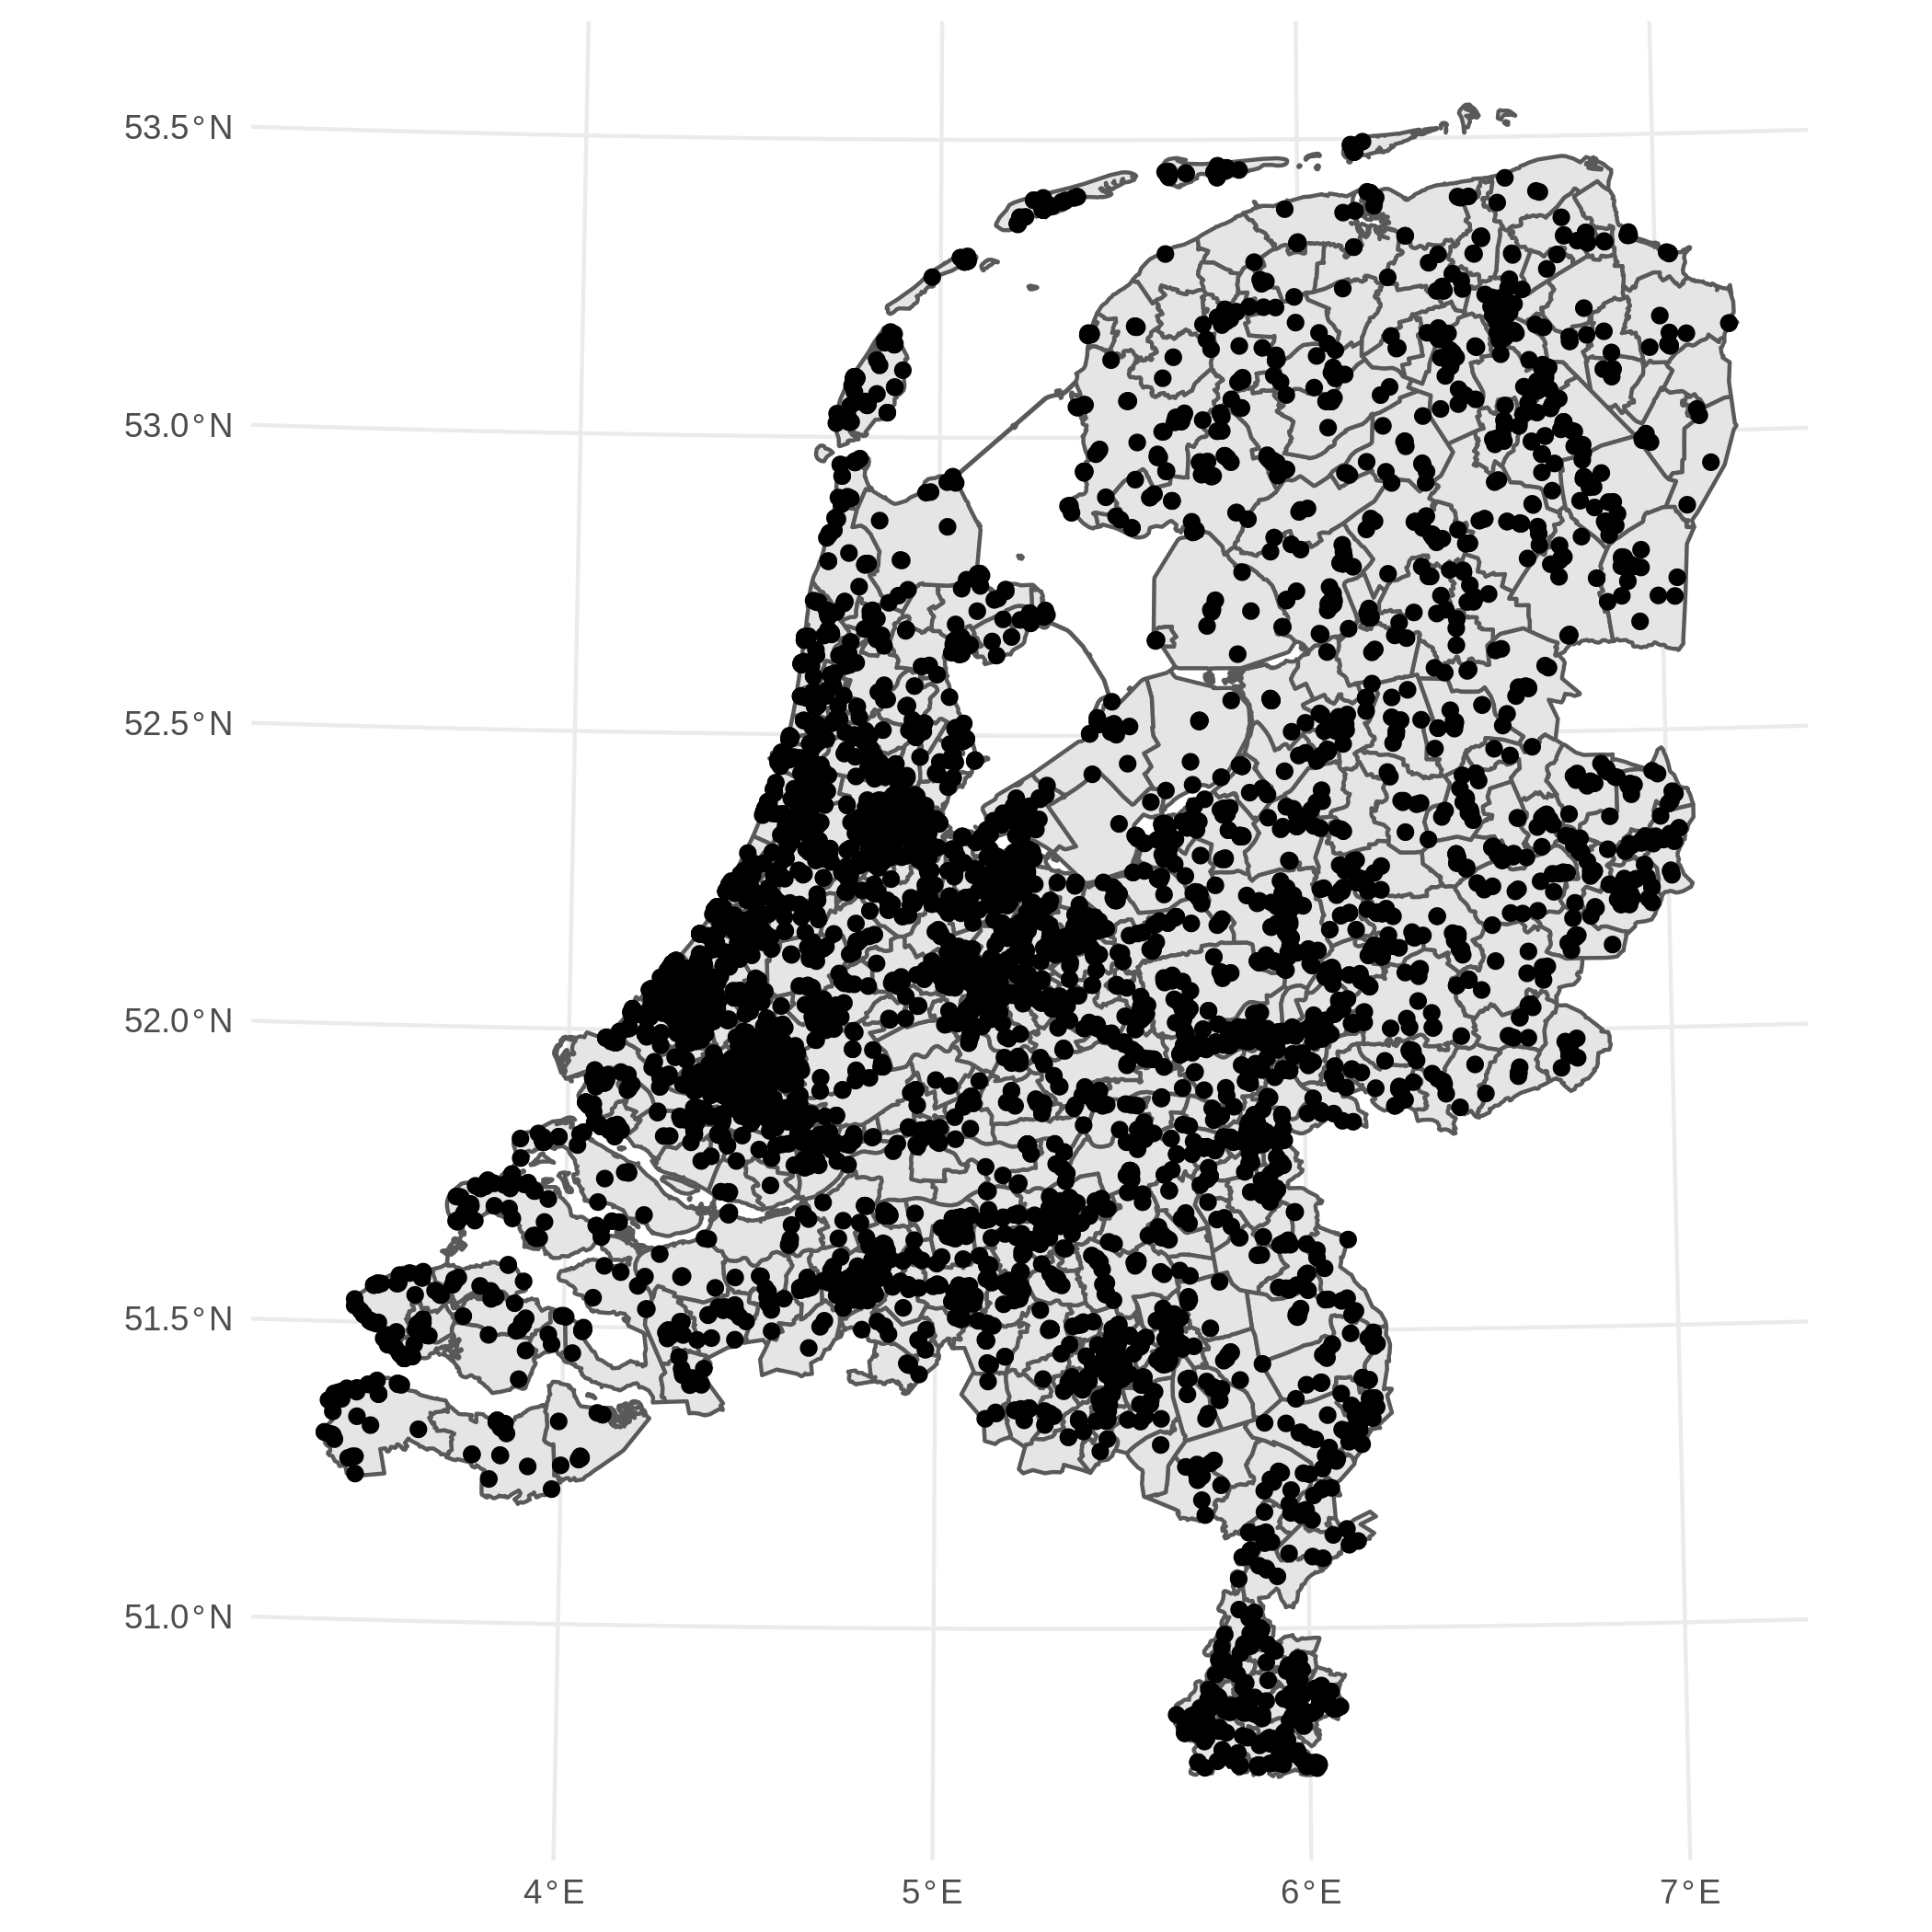

In [8]:
# plot locations on the map
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 300) # set size of plots
ggplot() +
  geom_sf(data = municipalBoundaries) +
  geom_sf(data = locations) +
  theme_minimal()

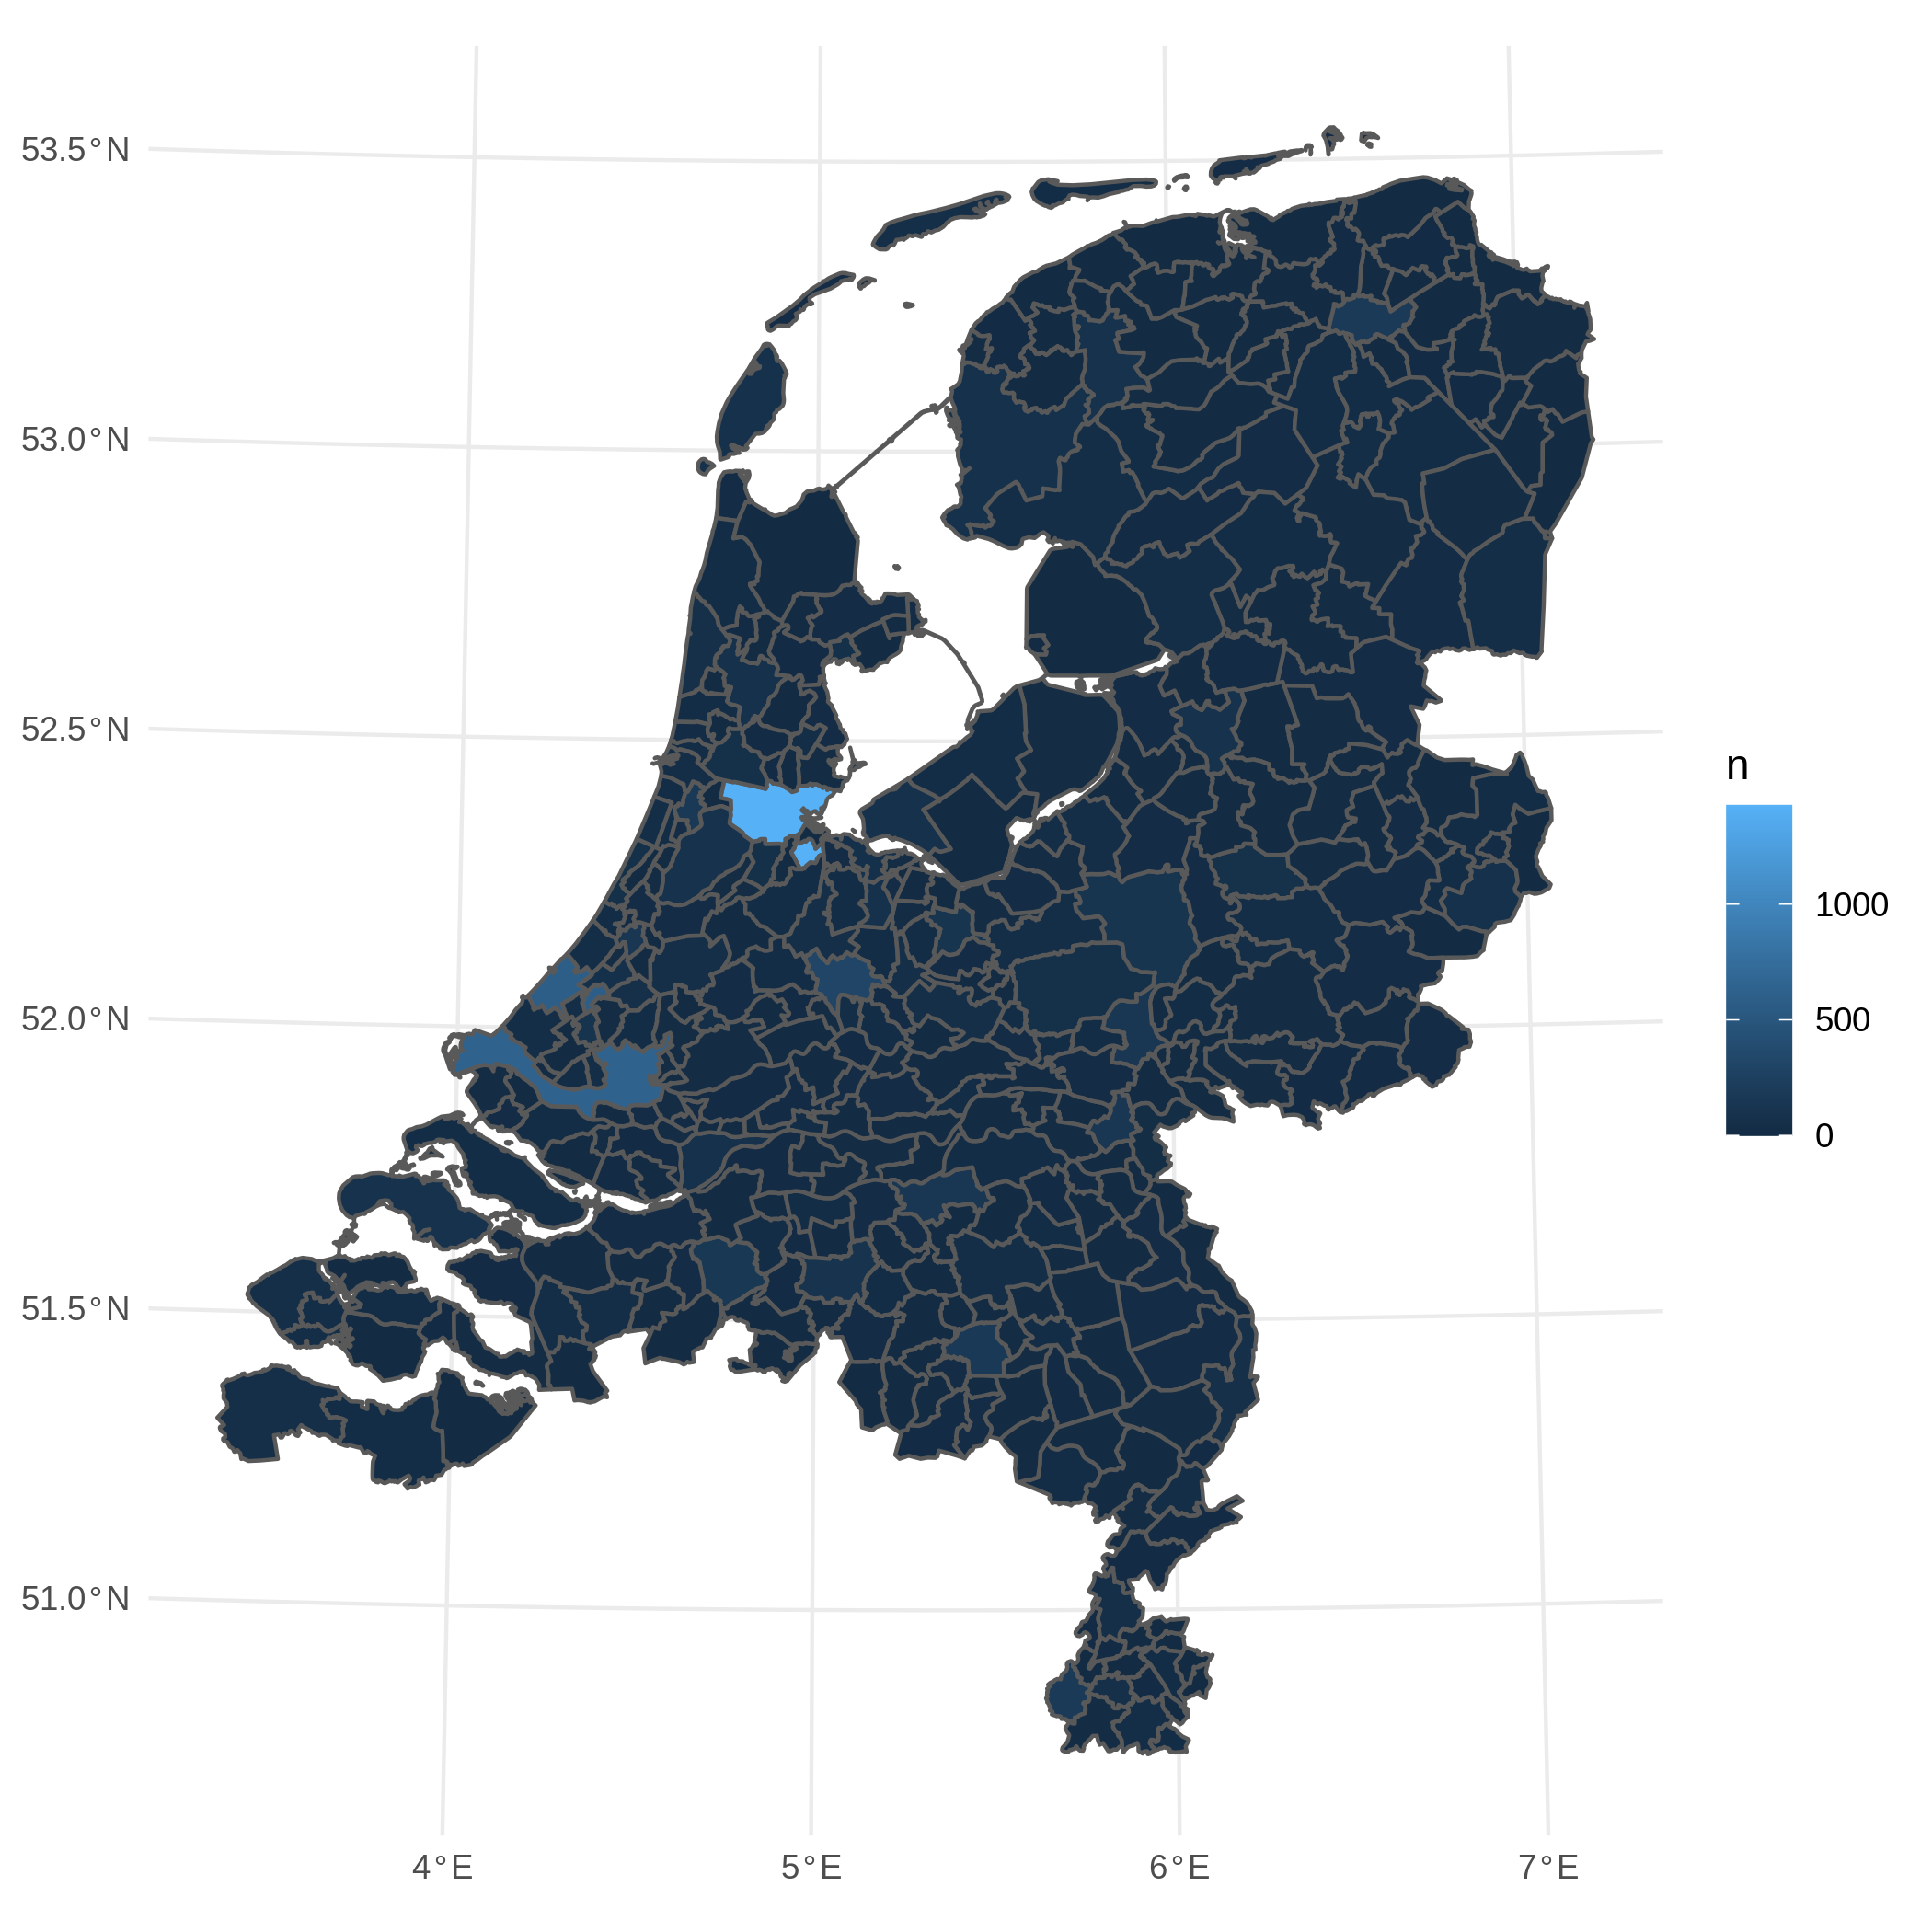

In [9]:
# colour by number of restaurants per municipality
locations_count <- 
  st_join(municipalBoundaries, locations) %>% # spatial join to get intersection of points and polygons
  drop_na() %>% # watch out - NA is counted as a one observation so drop it
  group_by(id) %>%
  tally()
# fill missing `n` with 0
tmp <- municipalBoundaries %>%
 select(id, geometry) %>% filter(! id %in%  (locations_count %>% as_tibble() %>% select(id) %>% pull())) %>% mutate(n = 0)

locations_count <- locations_count %>% bind_rows(tmp) 

ggplot() +
  geom_sf(data = locations_count, aes(fill = n)) +
  theme_minimal()  

# Leiden restaurants

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


,postcode,centroide_rd
,<chr>,<POINT [m]>
1,2332AA,POINT (92409.23 464047.5)


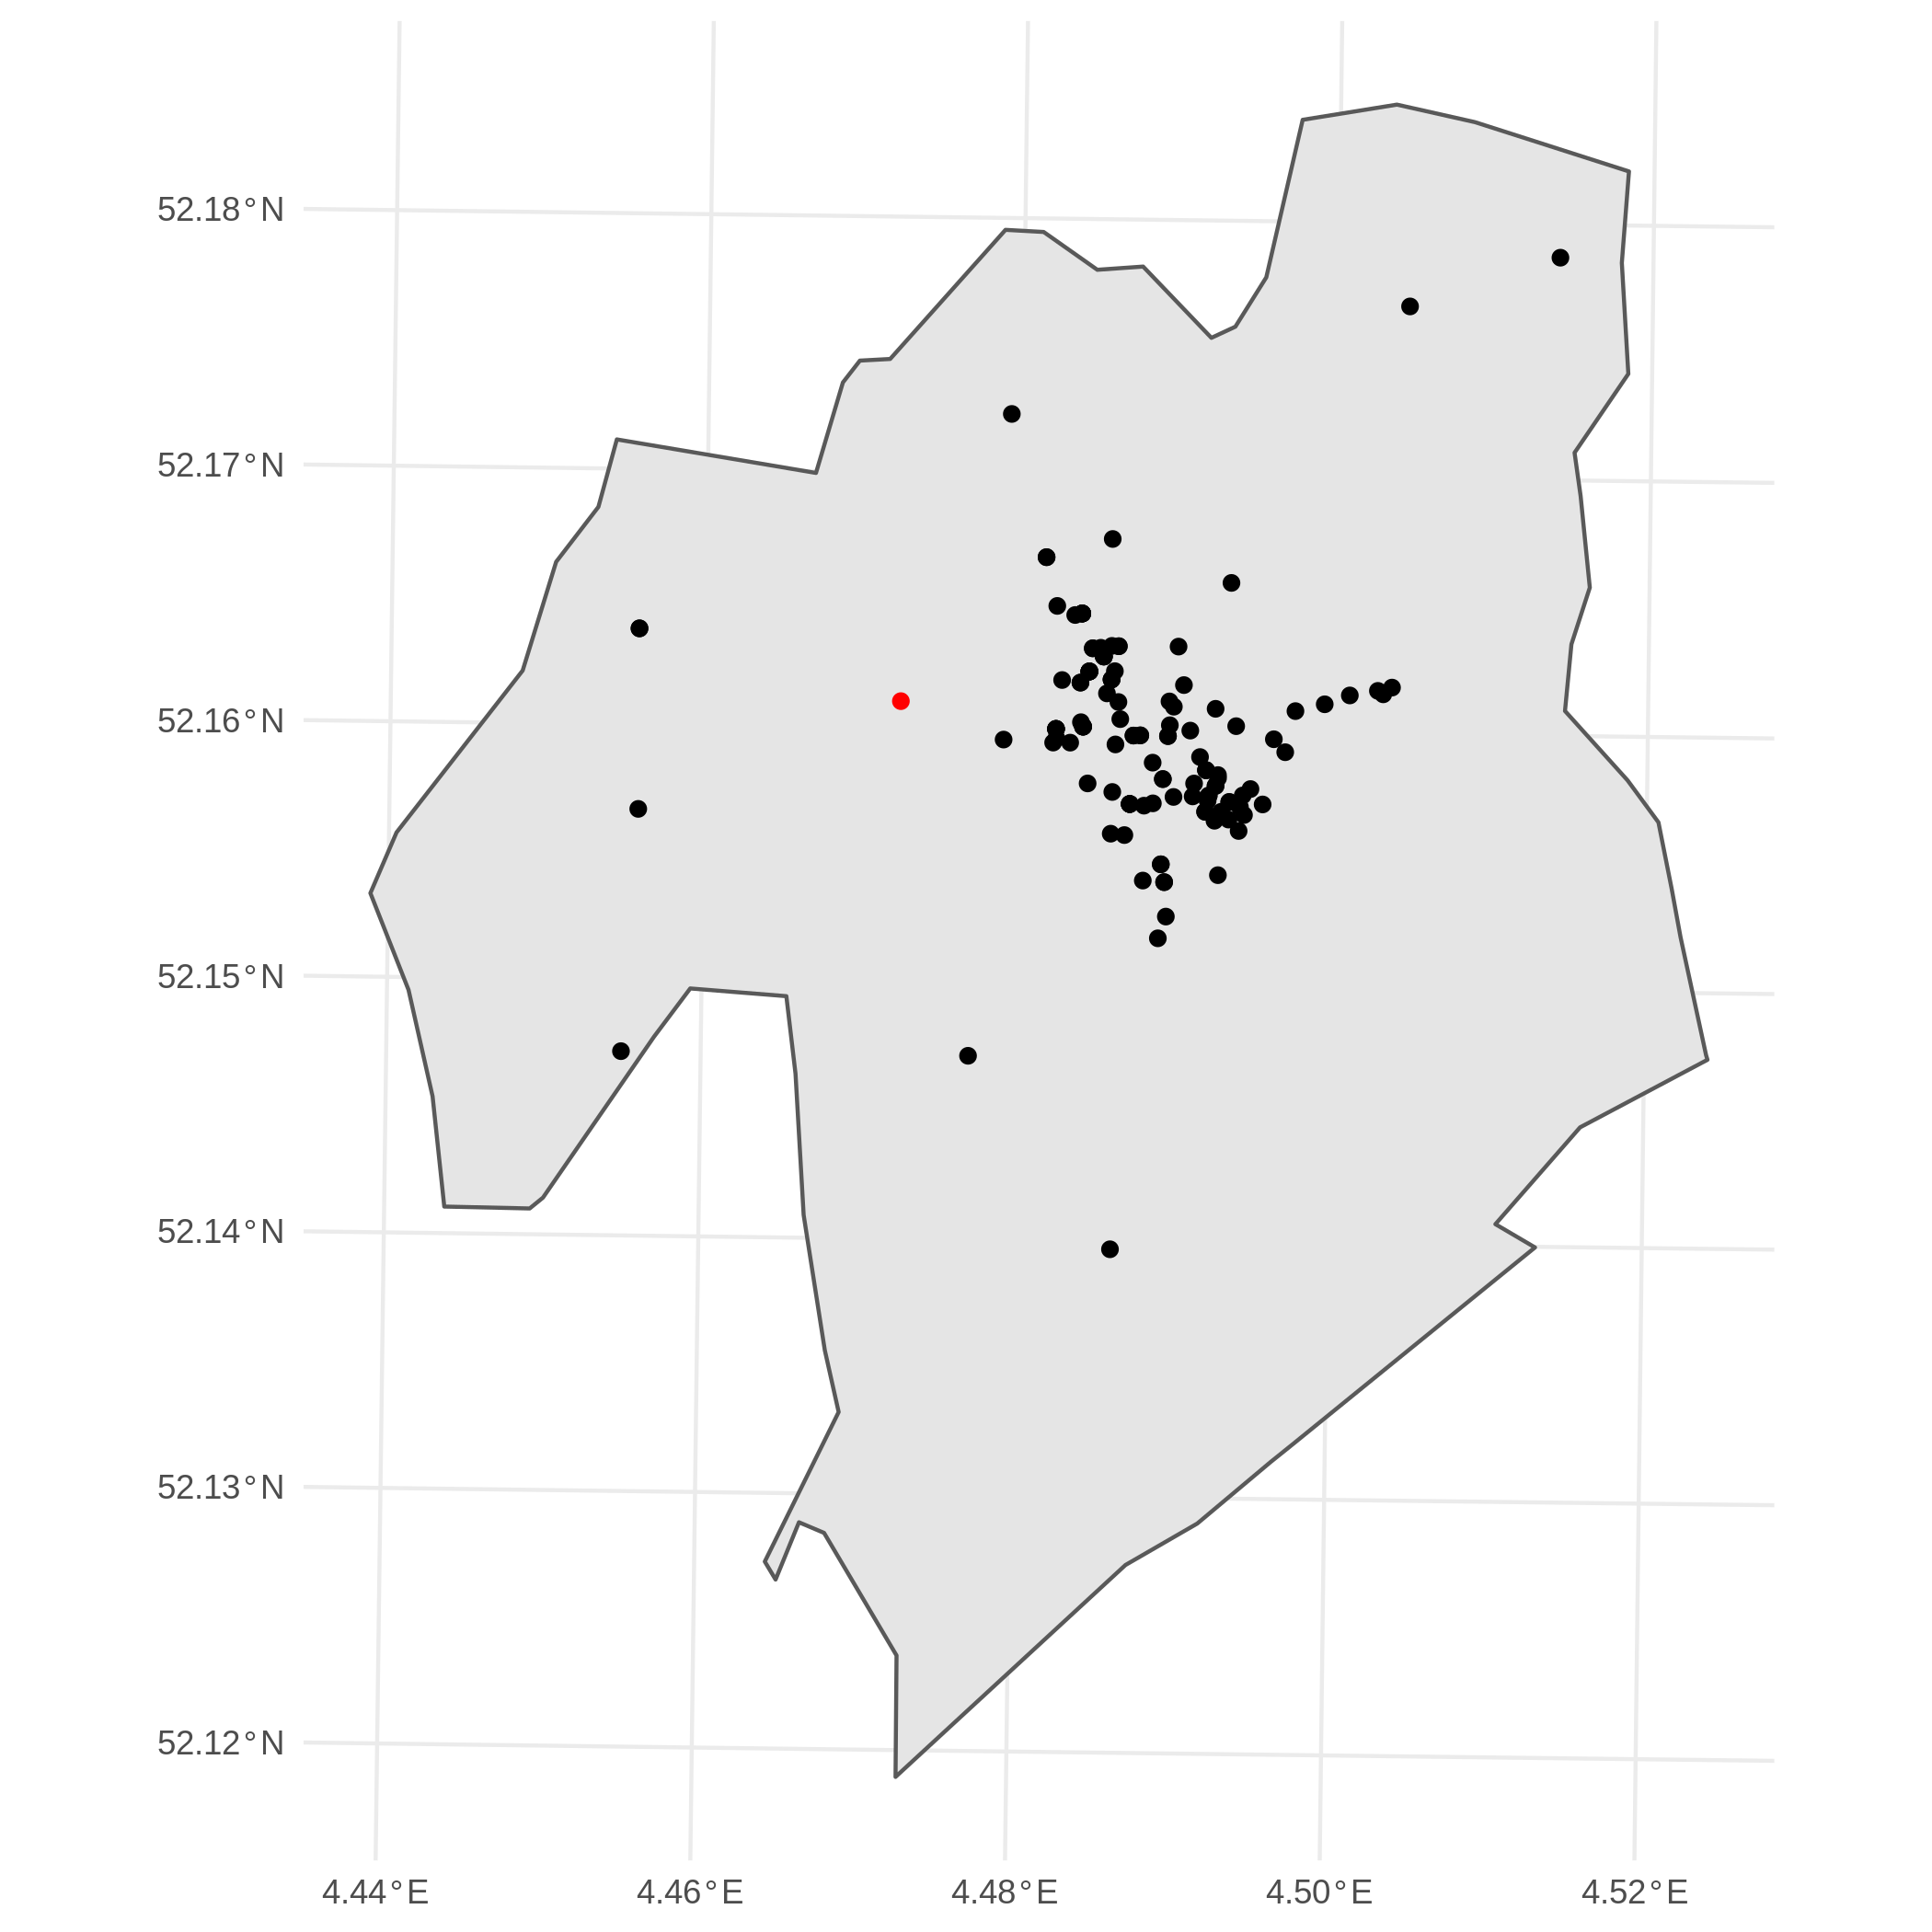

In [10]:
# just Leiden restaurants
locations_leiden <- municipalBoundaries %>% filter(statnaam == 'Leiden') %>% st_intersection(locations) %>% distinct()
# Leiden t.b office
office = "2332AA" %>% 
  {sprintf("type:postcode+AND+postcode:/.*%s.*/", .)} %>%
  {sprintf("http://geodata.nationaalgeoregister.nl/locatieserver/free?fq=%s&start=0&rows=1", .)} %>%
  fromJSON(.) %>%
  .[['response']] %>% .[['docs']] %>% 
  select(centroide_rd, postcode) %>%
  st_as_sf(wkt = "centroide_rd") %>%
  st_set_crs(st_crs(municipalBoundaries))
office  

ggplot() +
  geom_sf(data = (municipalBoundaries %>% filter(statnaam == 'Leiden'))) +
  geom_sf(data = locations_leiden) +
  geom_sf(data = office, aes(colour = "red")) +
  scale_color_identity() +
  theme_minimal() 



# Propose the 'best' track route to deliver fresh fruit

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



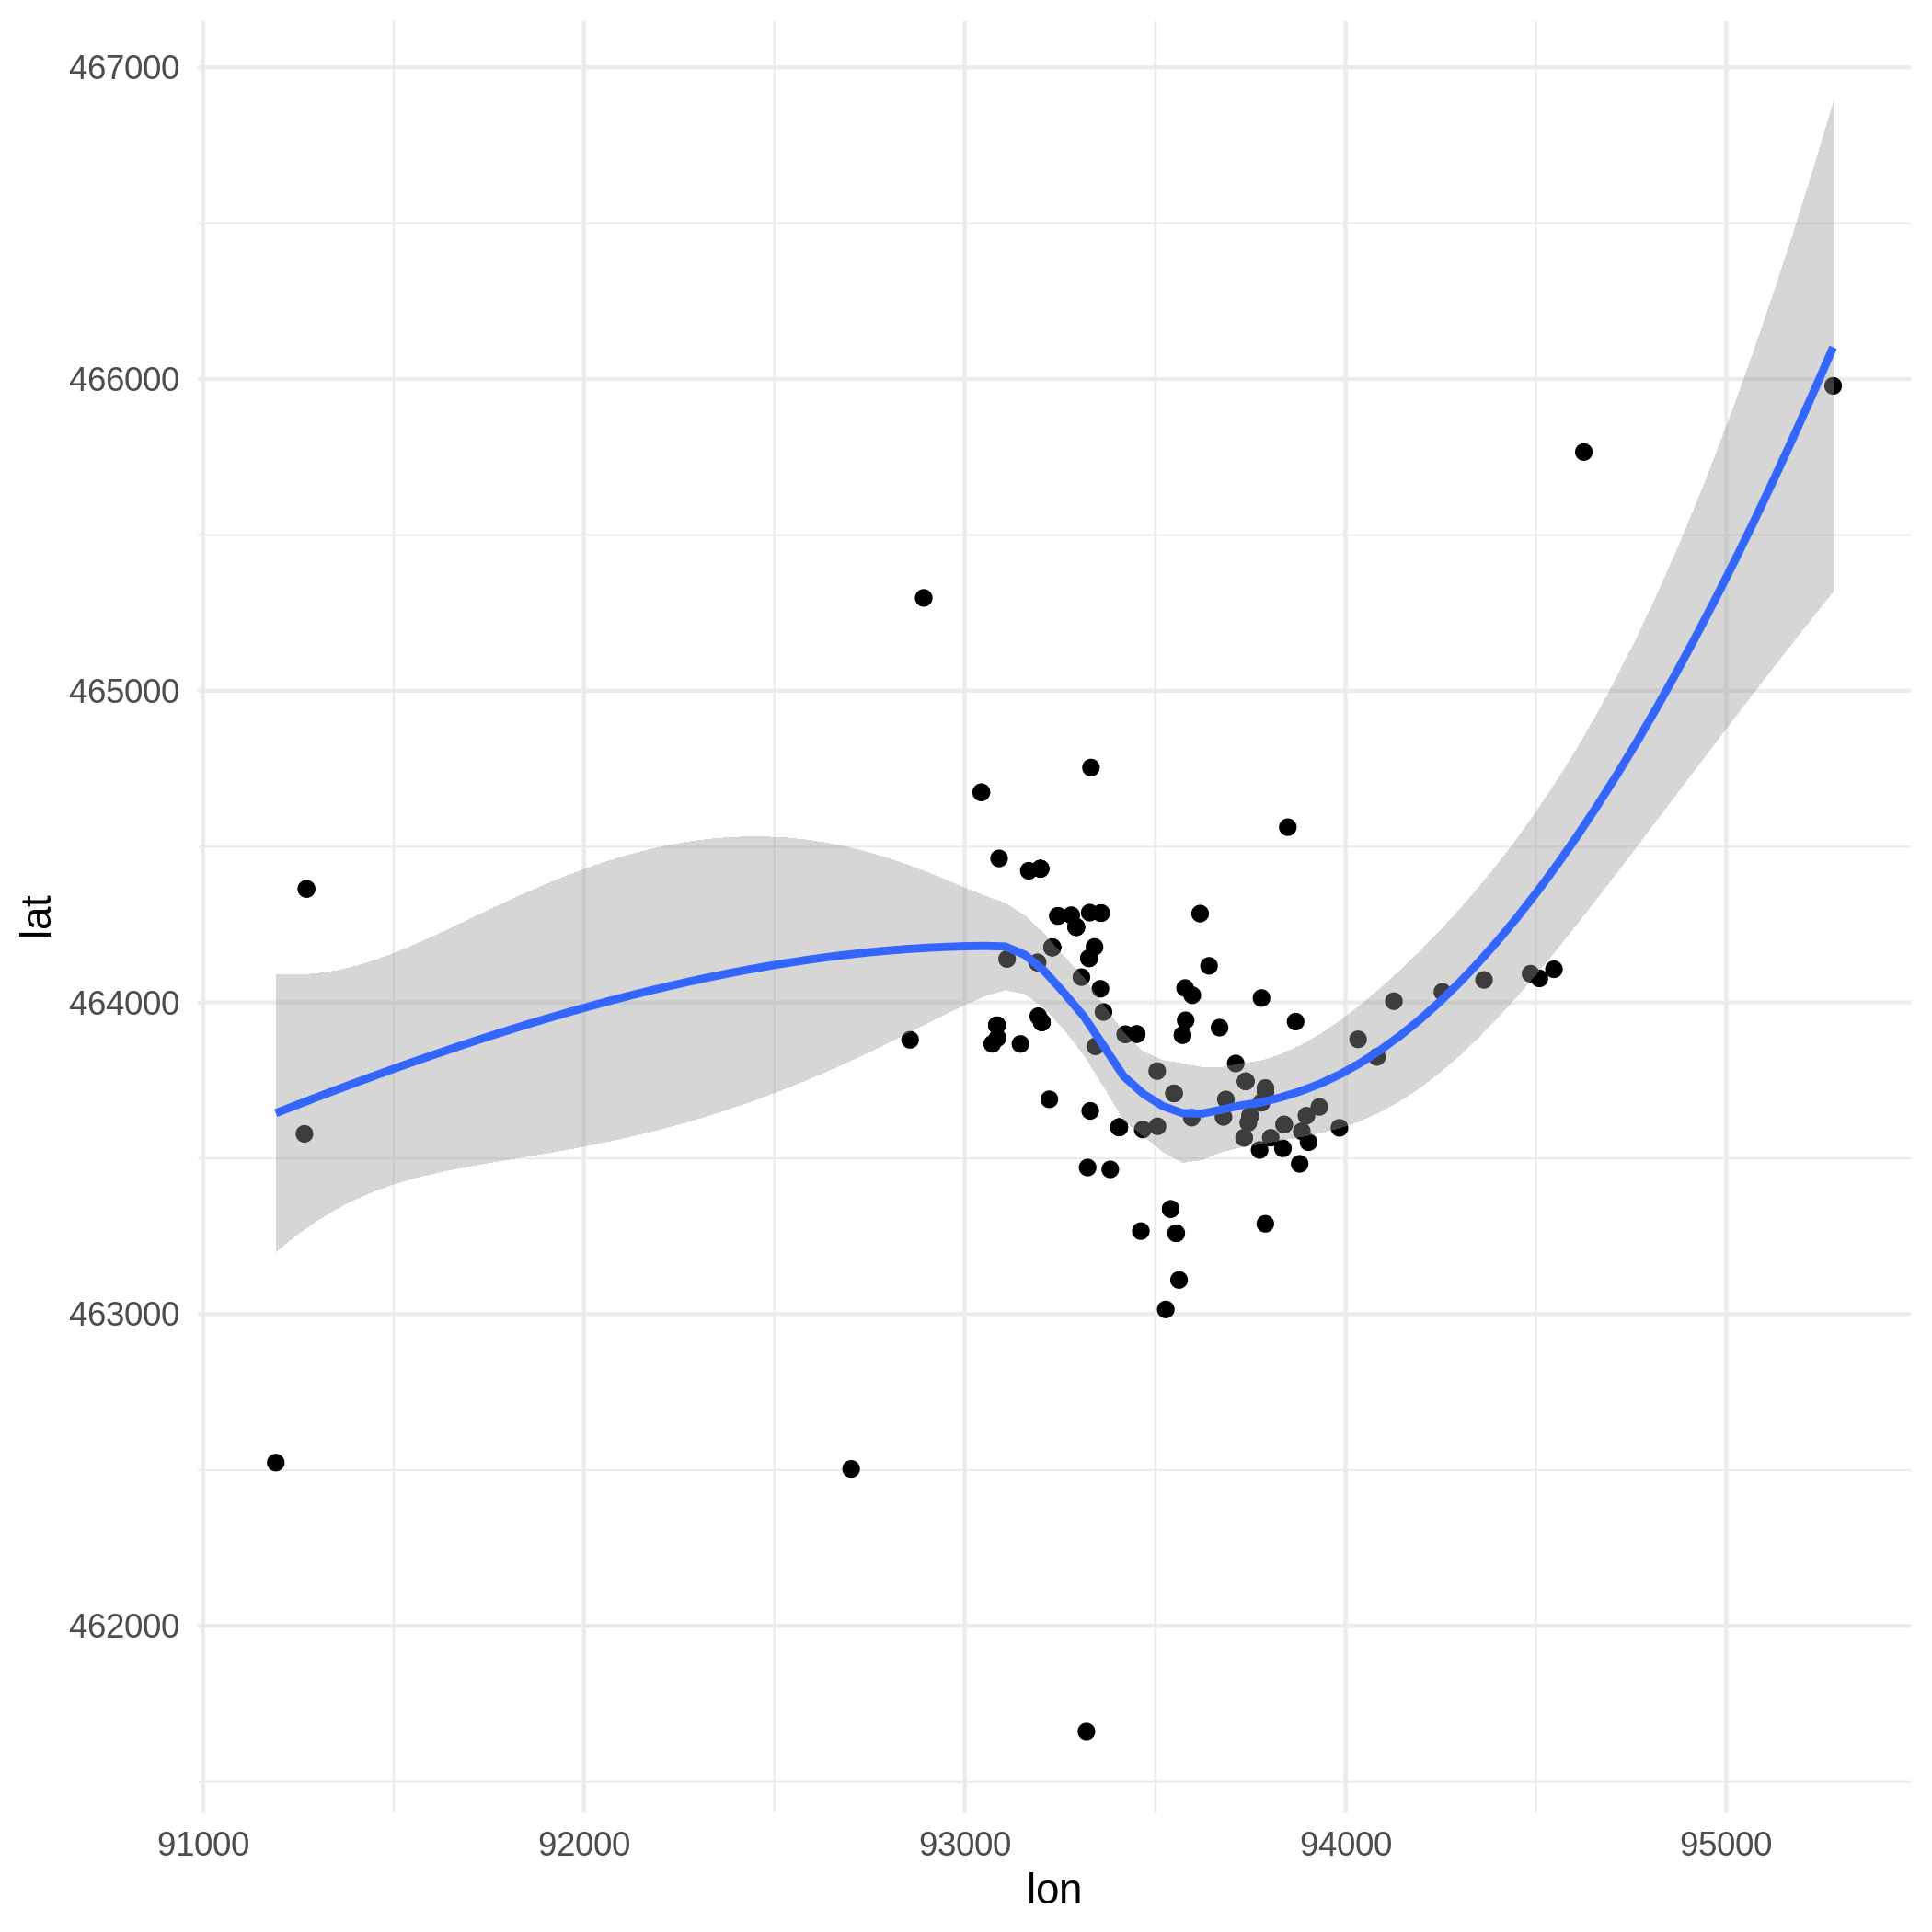

In [38]:
locations_leiden %>% st_geometry() %>% unlist() %>% 
  matrix(ncol=2,byrow=TRUE) %>% 
  as_tibble() %>% 
  setNames(c("lon","lat")) %>% 
  ggplot() +
  aes(x = lon, y = lat) +
  geom_point() +
  geom_smooth() +
  theme_minimal() 


# Number of Leiden restaurants vs population in a city zipcode area

In [11]:
# install more packages
install.packages("cbsodataR")
install.packages('stars')
install.packages('spdep')
install.packages('dbscan')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“not all columns named in 'colClasses' exist”
Joining, by = "Postcode"


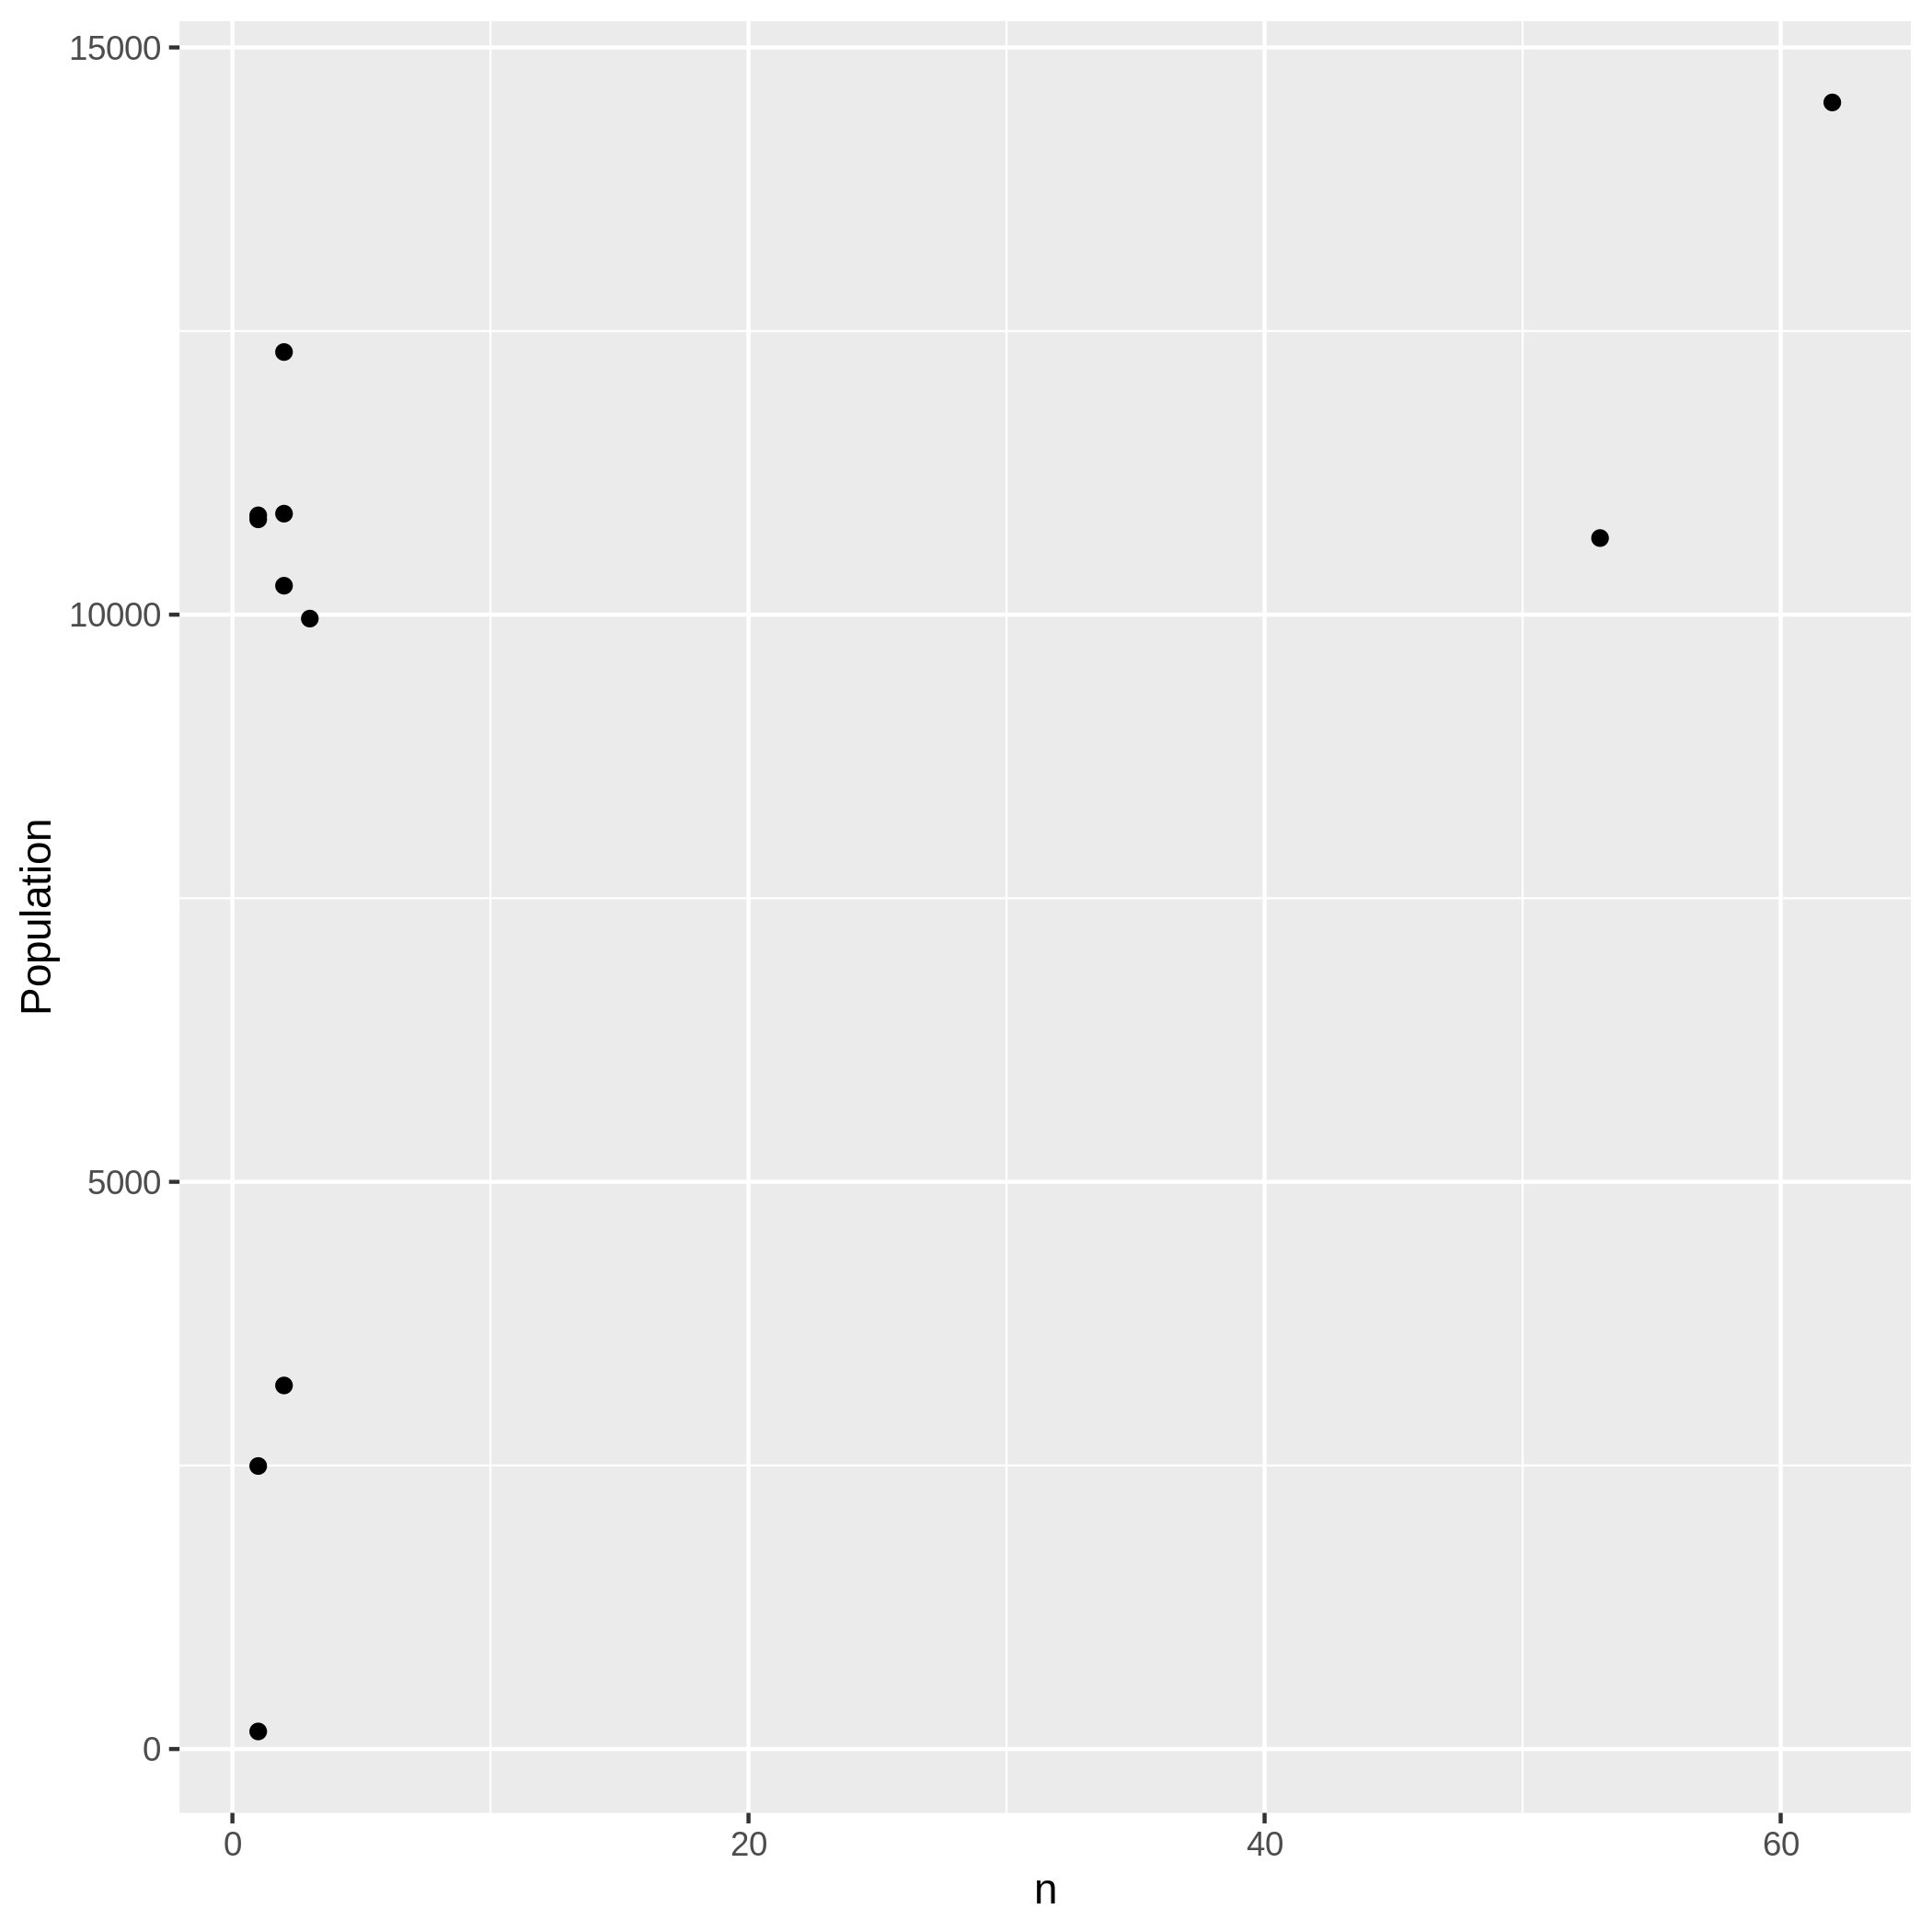

In [12]:
library(cbsodataR)
locations_leiden_grouped <- locations_leiden %>% mutate(postcode = str_extract(postcode, "\\d{4}")) %>% 
  mutate(postcode = paste("PC", postcode, "  ", sep = ""))  %>% 
  as_tibble() %>% select(postcode) %>% group_by(postcode) %>% tally() %>% rename(Postcode = postcode)

tbl <- cbs_get_data(
  id = "83503NED",
  Geslacht = "T001038", 
  Migratieachtergrond = c("T001040"), 
  Postcode = locations_leiden_grouped$Postcode, 
  Perioden = c("2021JJ00"), 
  select = c("Postcode", "Bevolking_1")) %>% rename(Population = Bevolking_1)

locations_leiden_grouped <- locations_leiden_grouped %>% left_join(tbl)
locations_leiden_grouped %>% ggplot() +
  aes(x = n, y = Population) +
  geom_point()


# Distance to nearest restaurant

Loading required package: abind



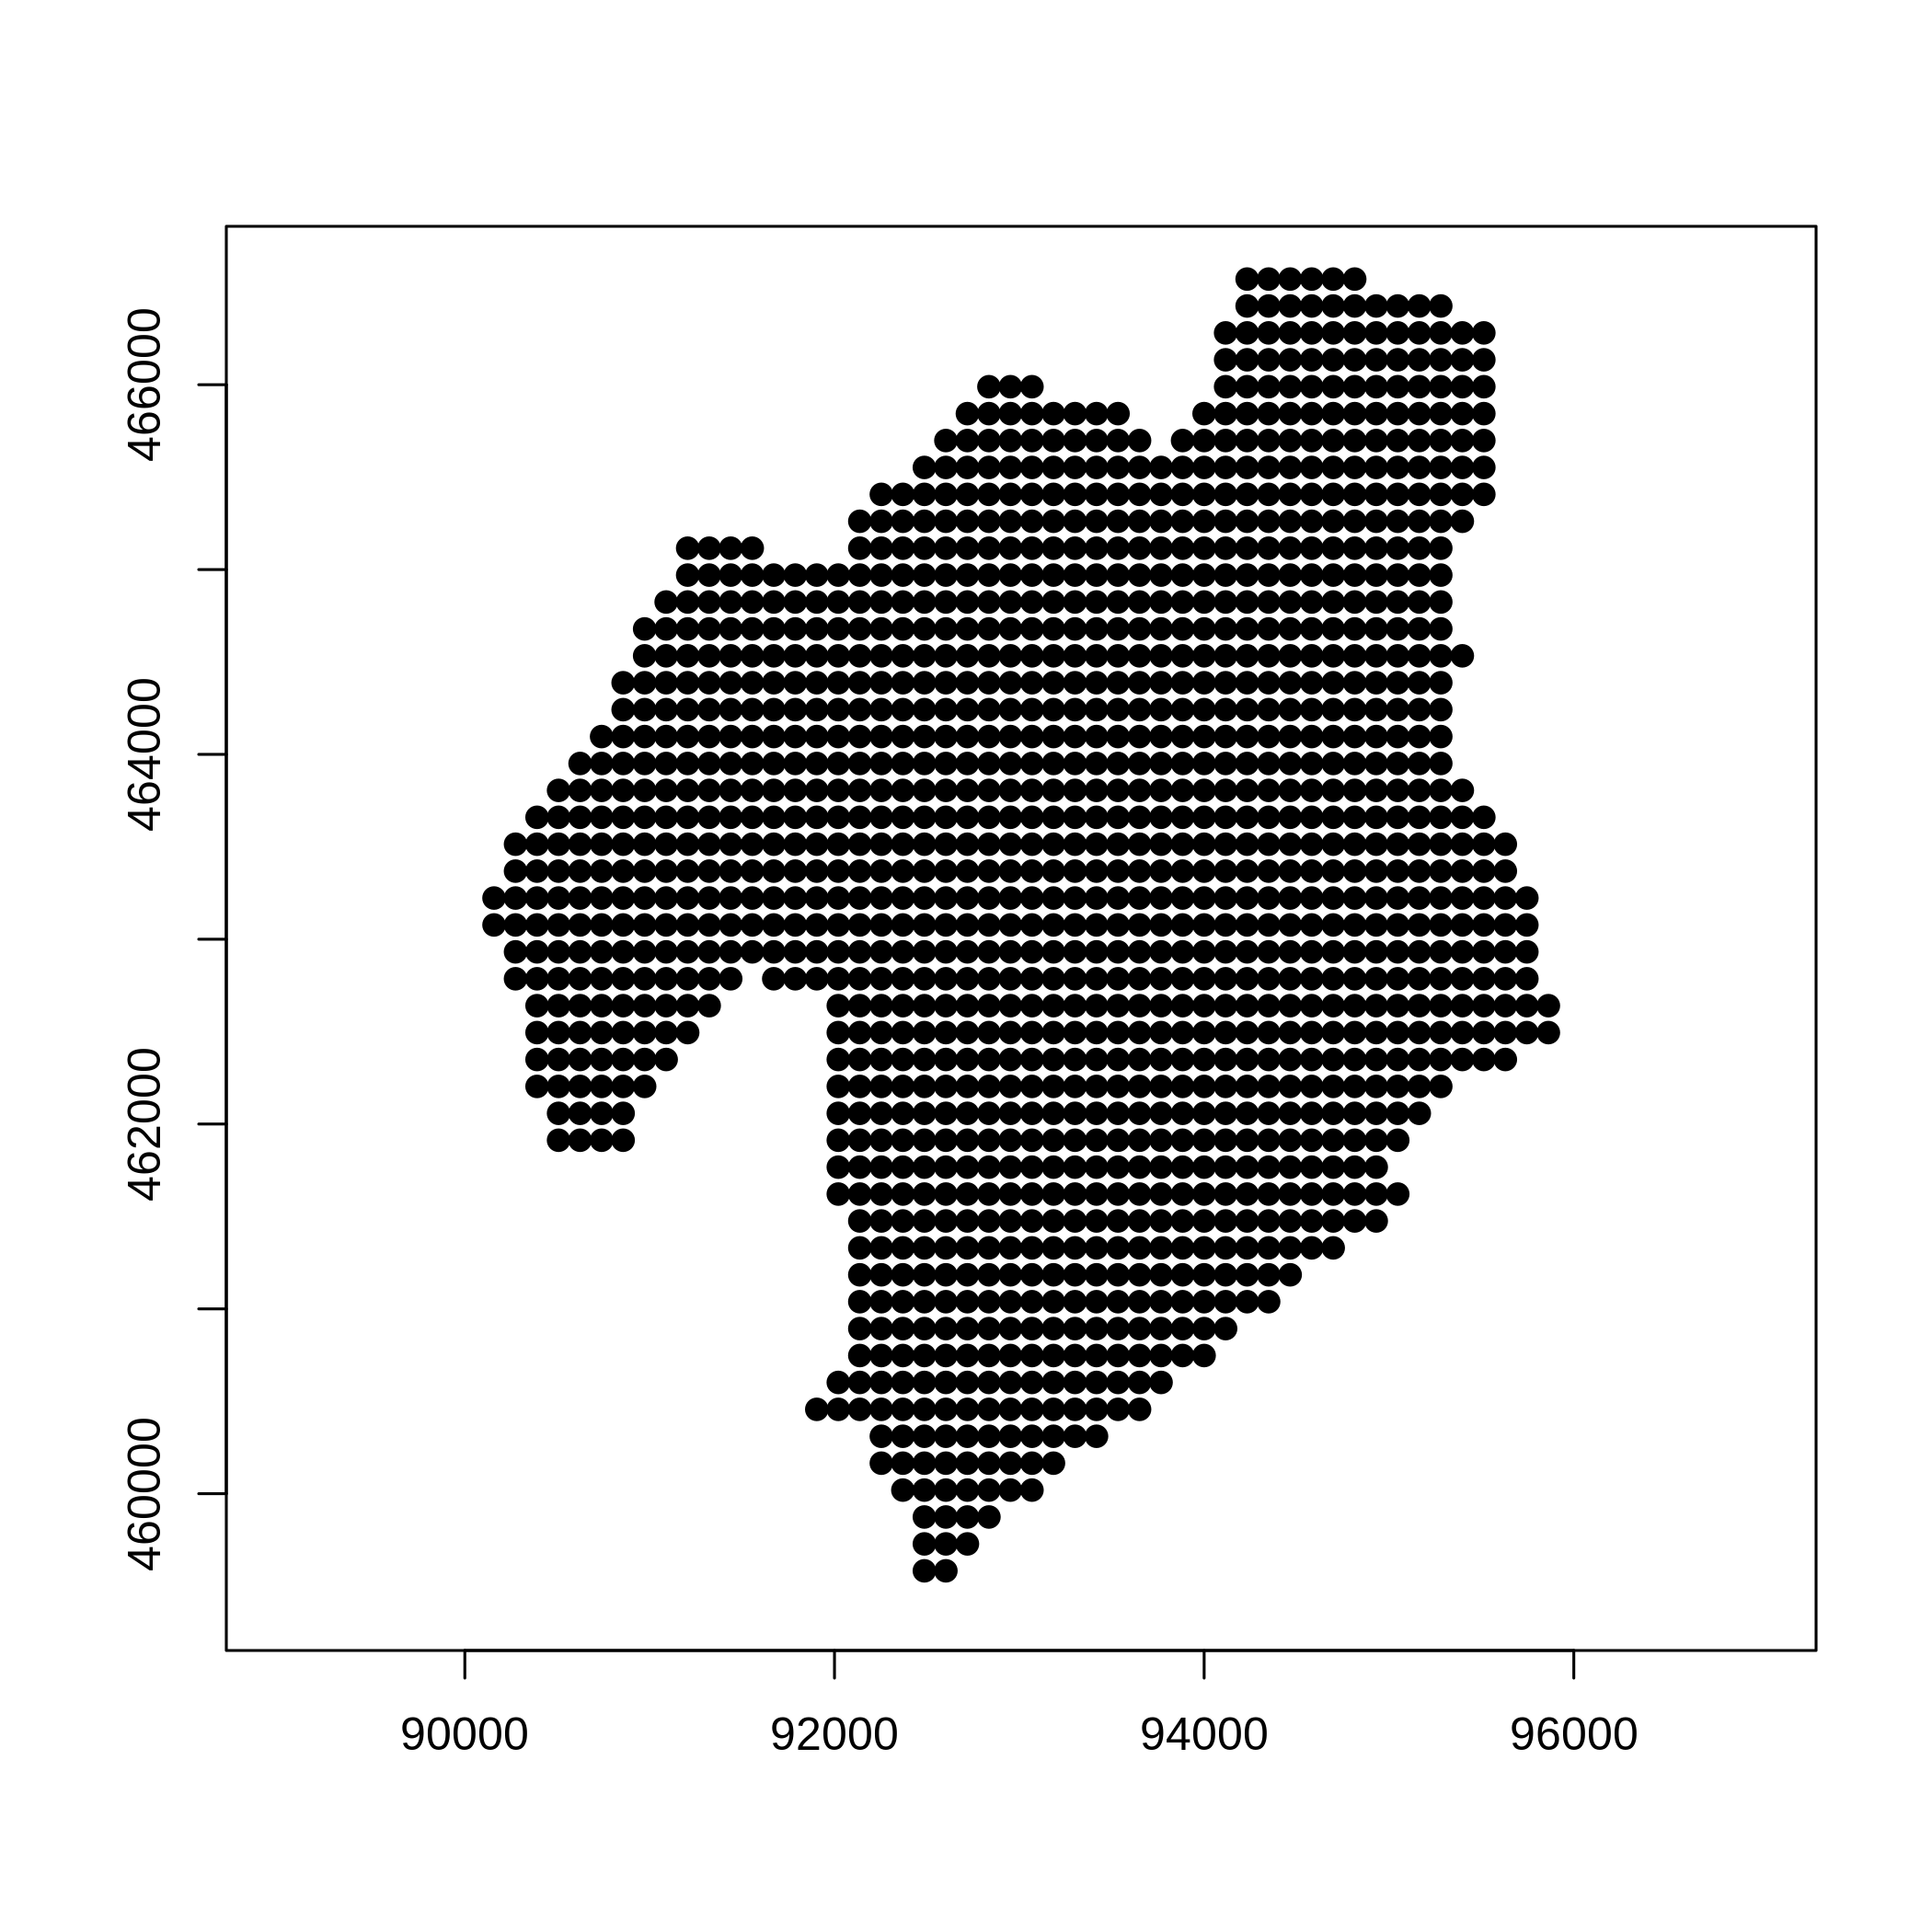

In [13]:
library(stars)
leiden <- (municipalBoundaries %>% filter(statnaam == 'Leiden'))
template = st_rasterize(leiden, st_as_stars(st_bbox(leiden), nx = 50, ny = 50, values = NA_real_))
grid = st_as_sf(template, as_points = TRUE)
grid$ID <- NULL
plot(grid, axes = TRUE, pch = 19)

udunits database from /usr/share/xml/udunits/udunits2.xml



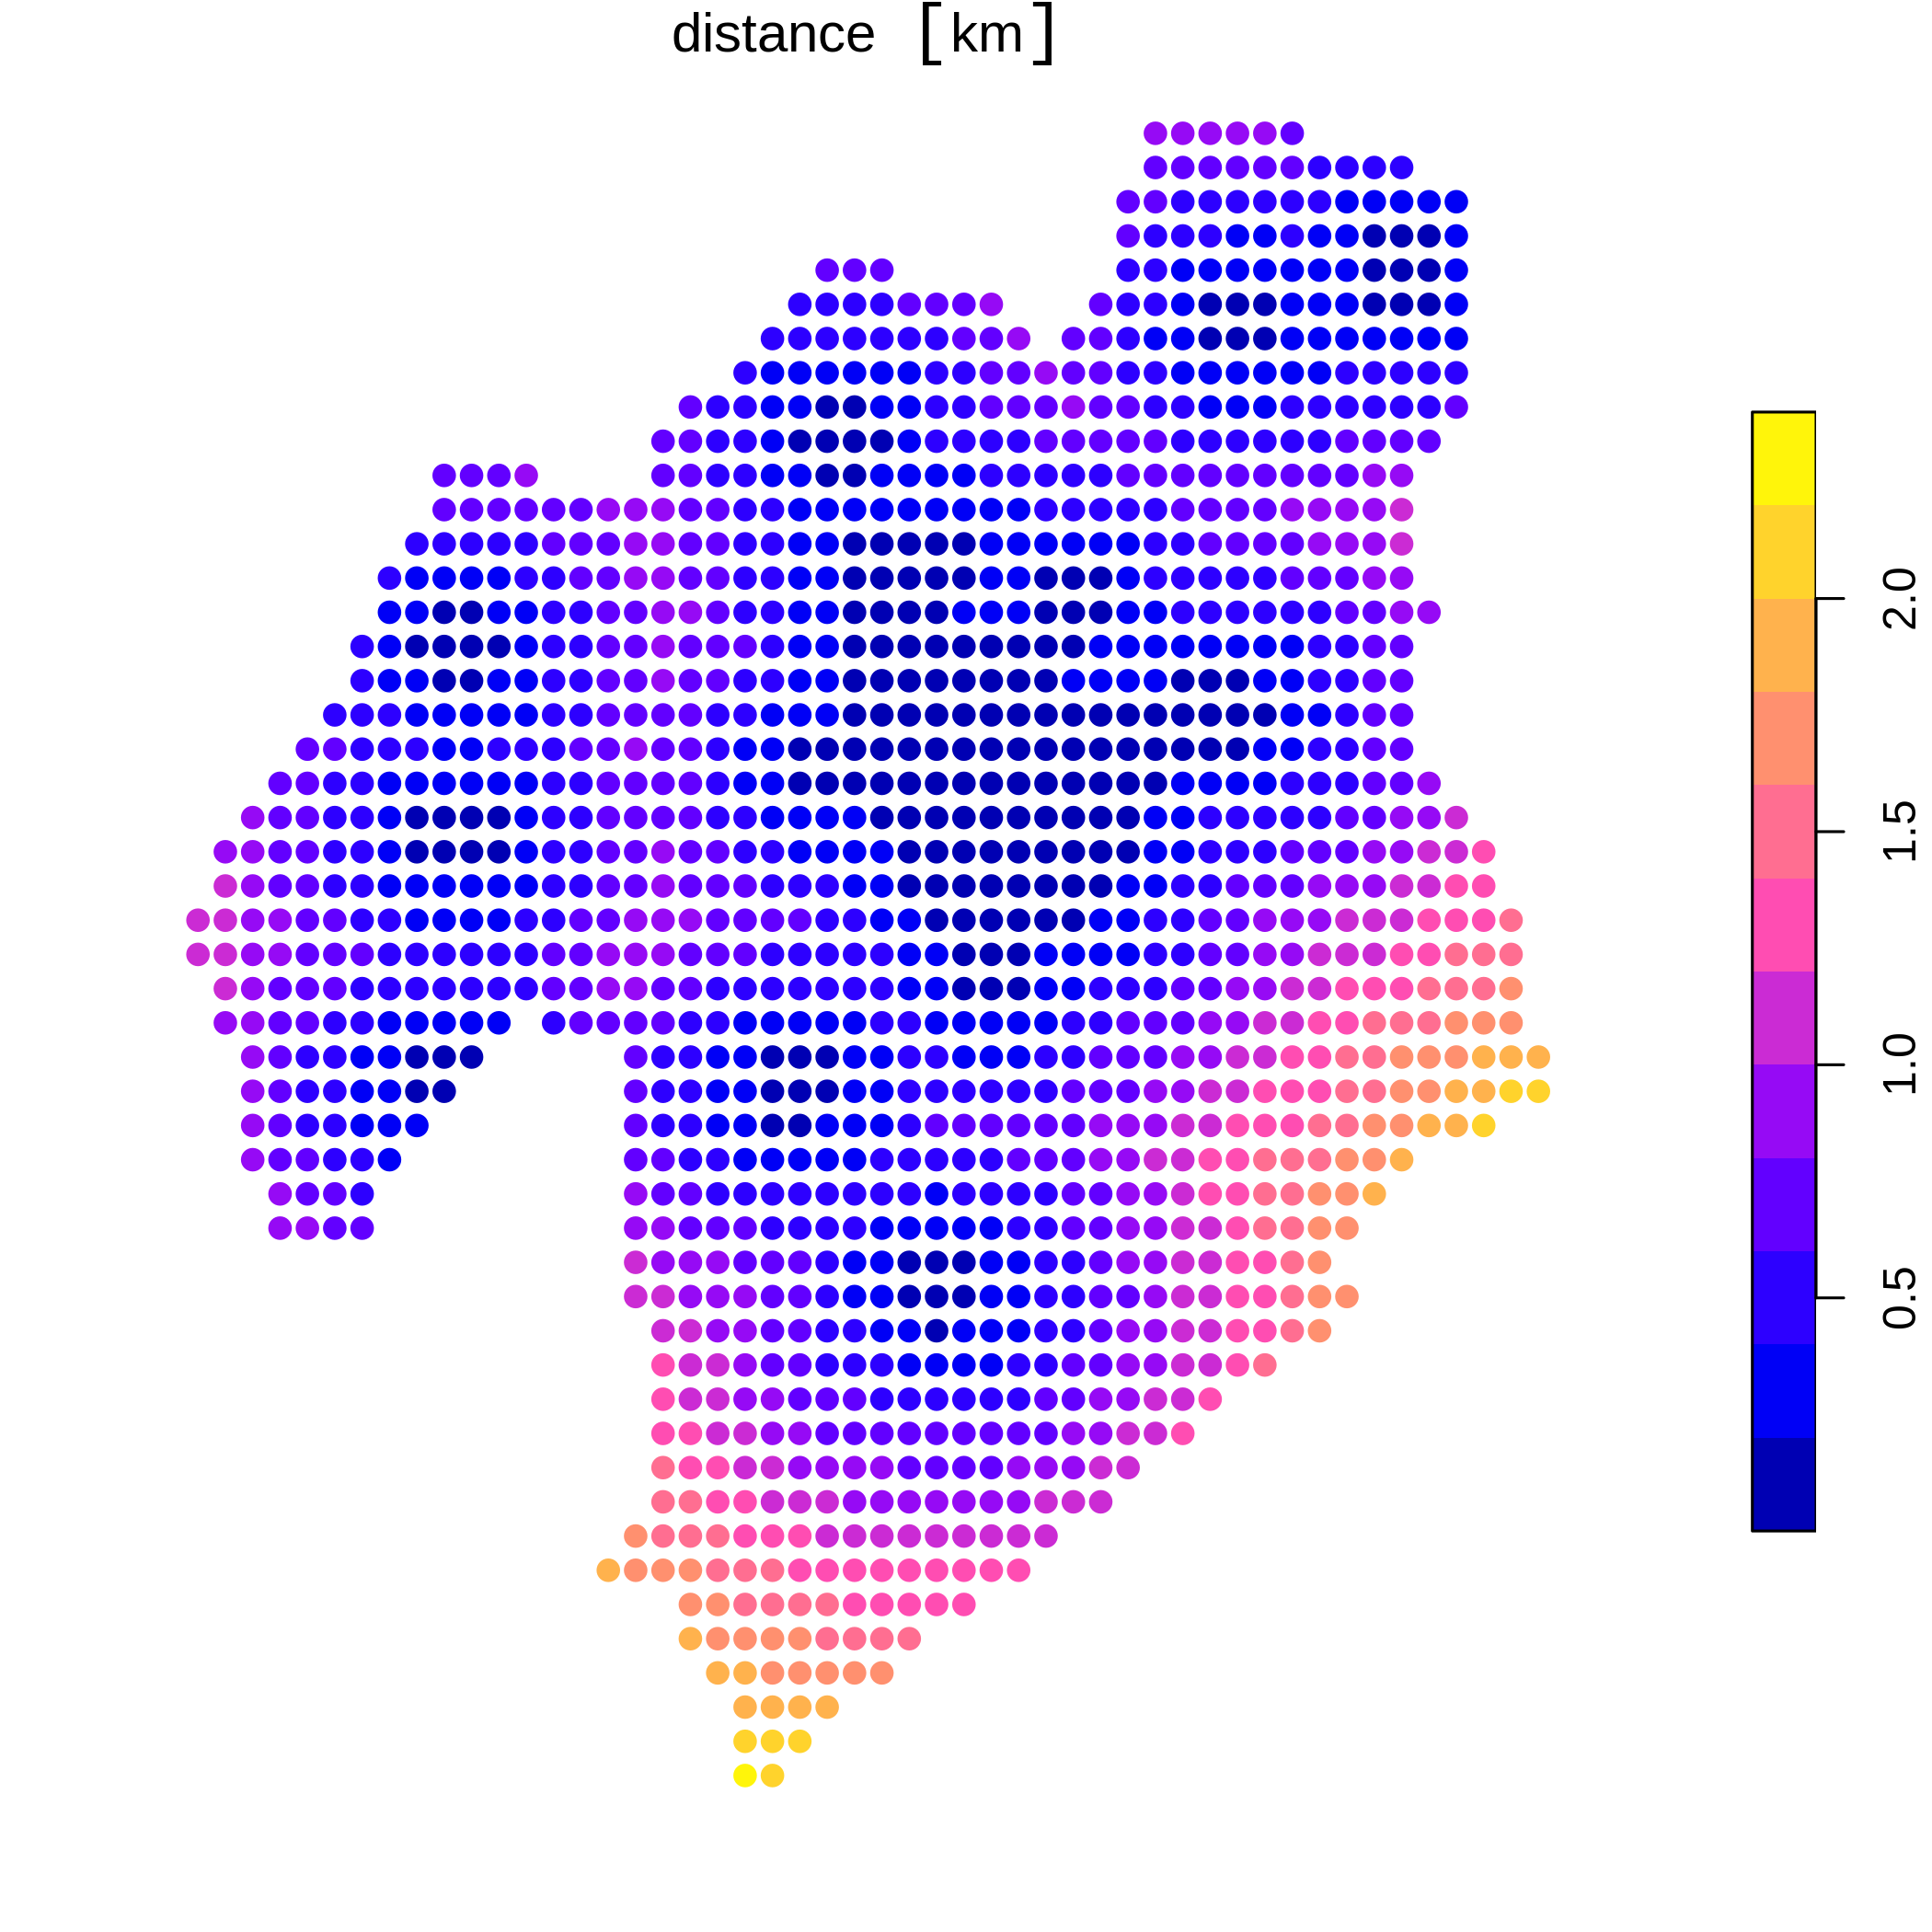

In [14]:
library(units)
distance = st_distance(grid, locations_leiden)
grid$distance = apply(distance, 1, min)
grid$distance = set_units(grid$distance, "m")
grid$distance = set_units(grid$distance, "km")
plot(grid, pch = 19)

# Restaurants counts in rasters

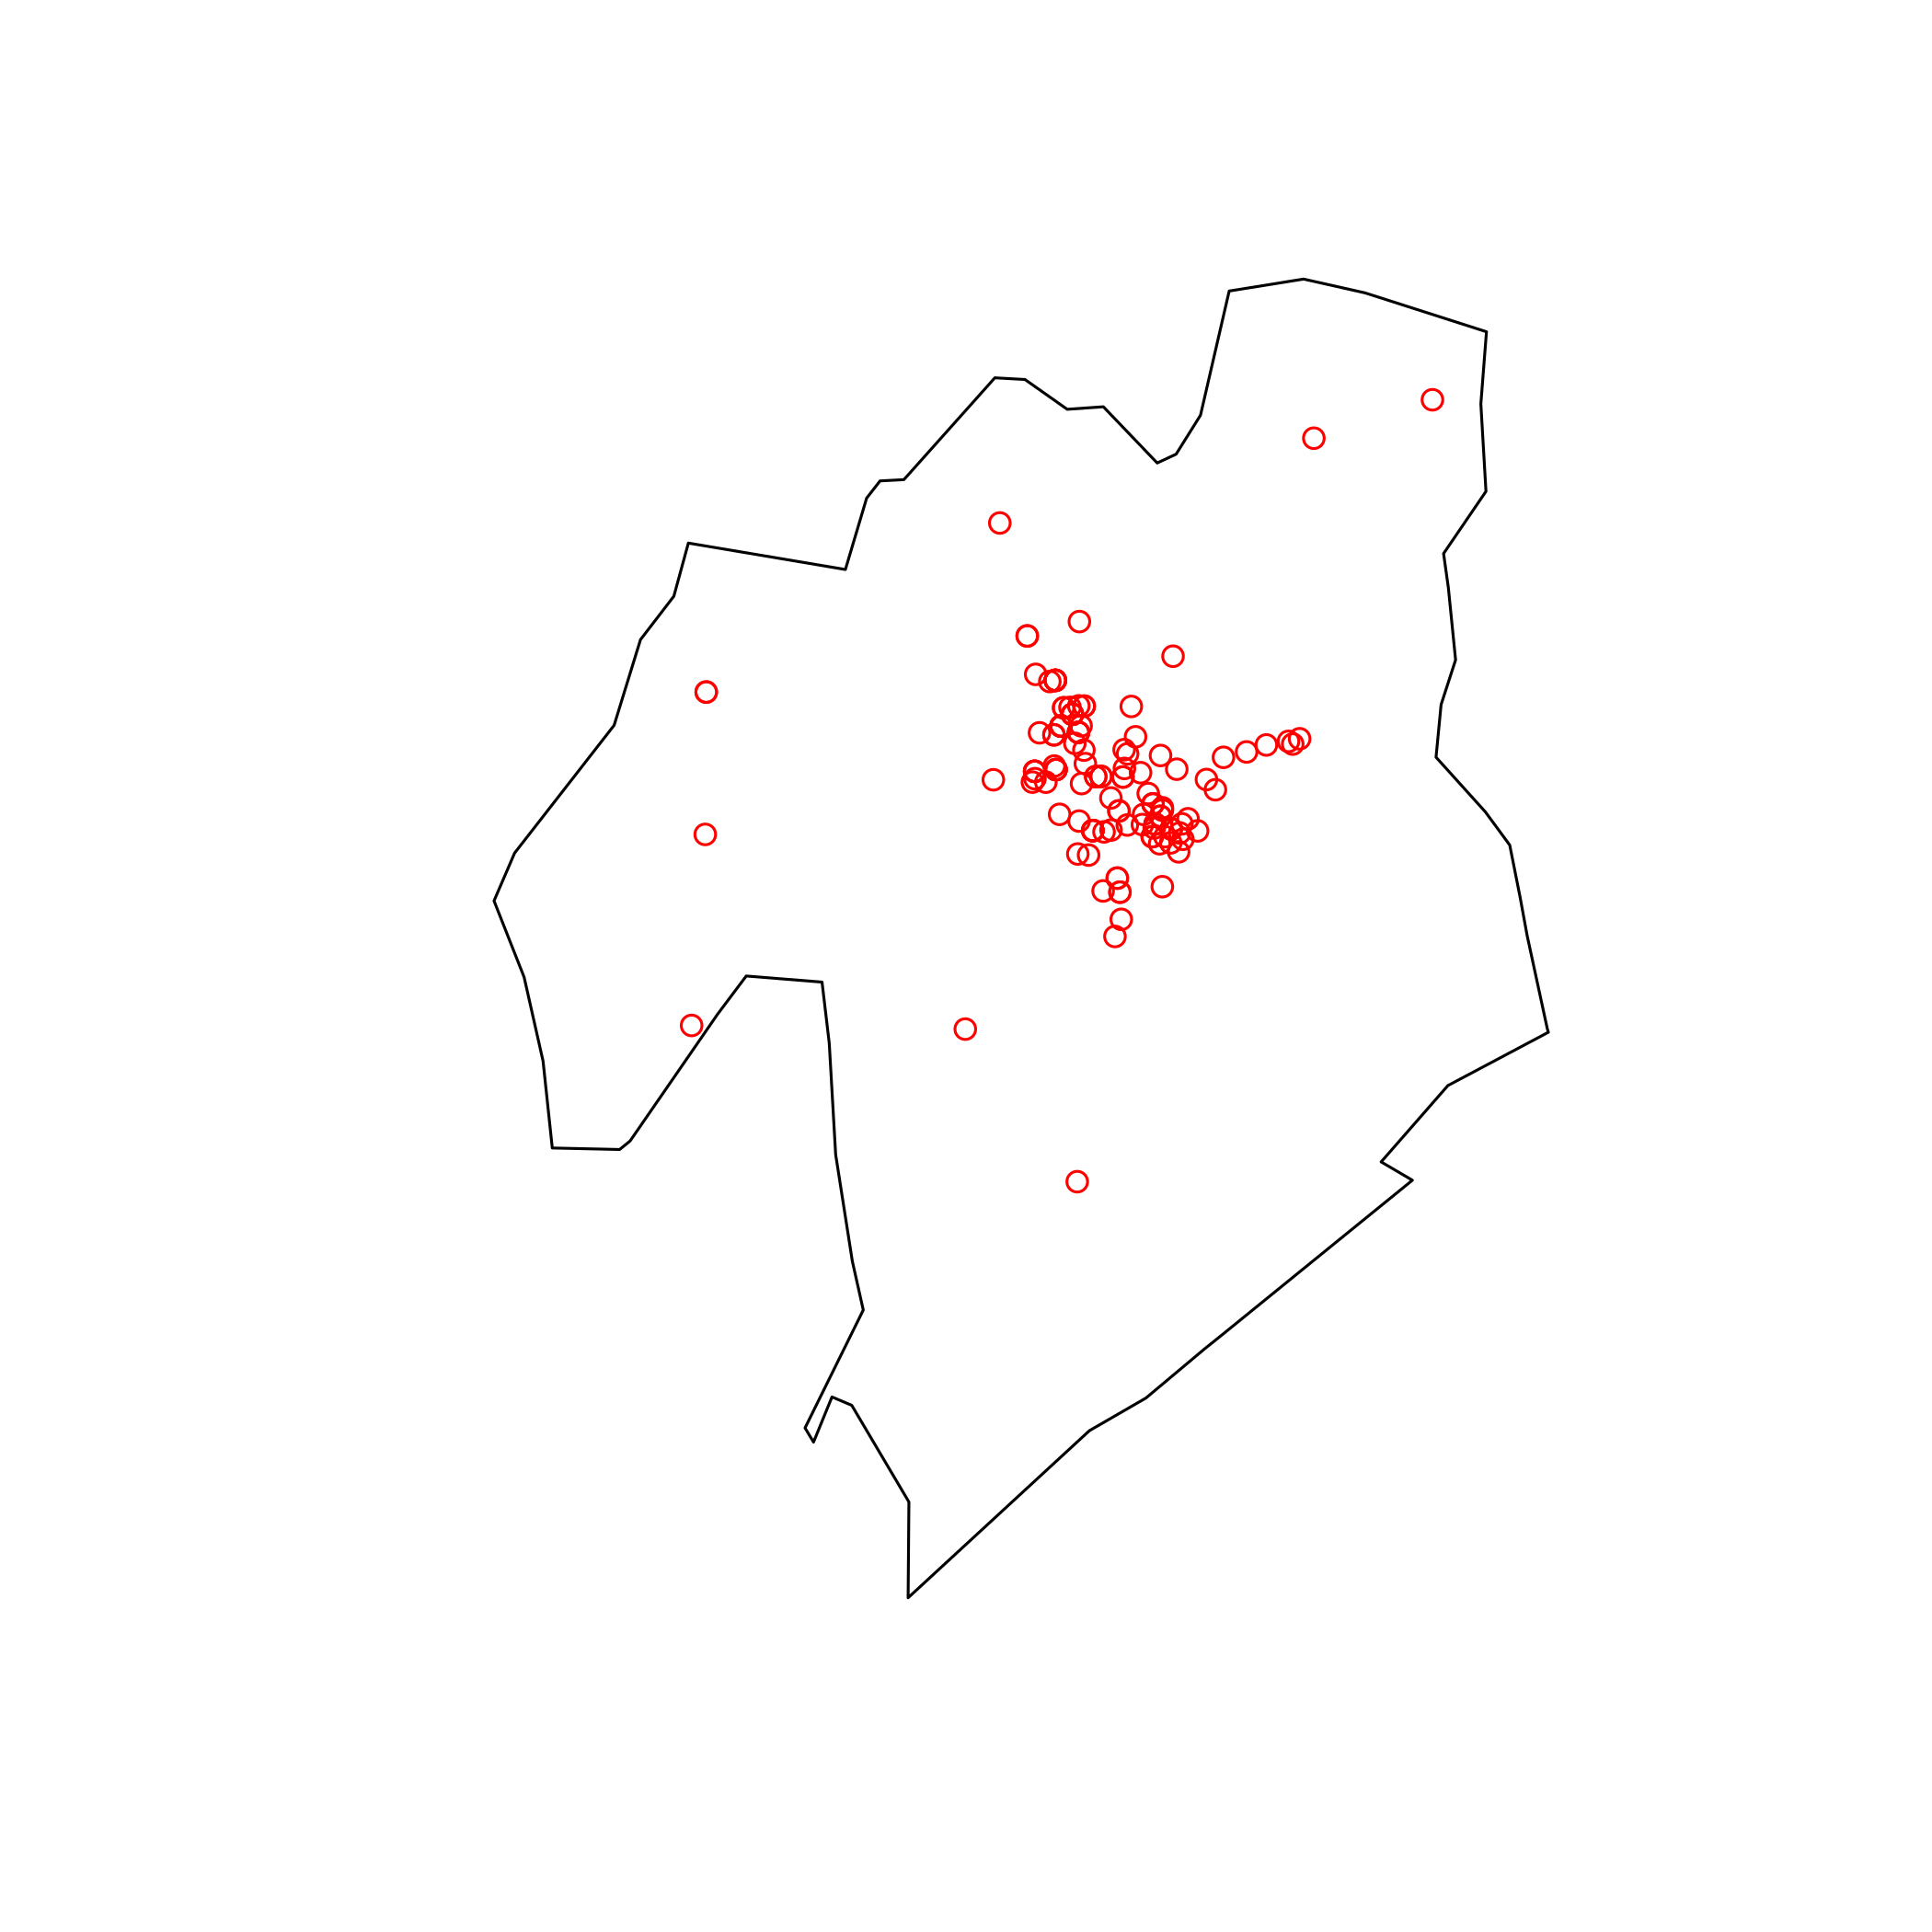

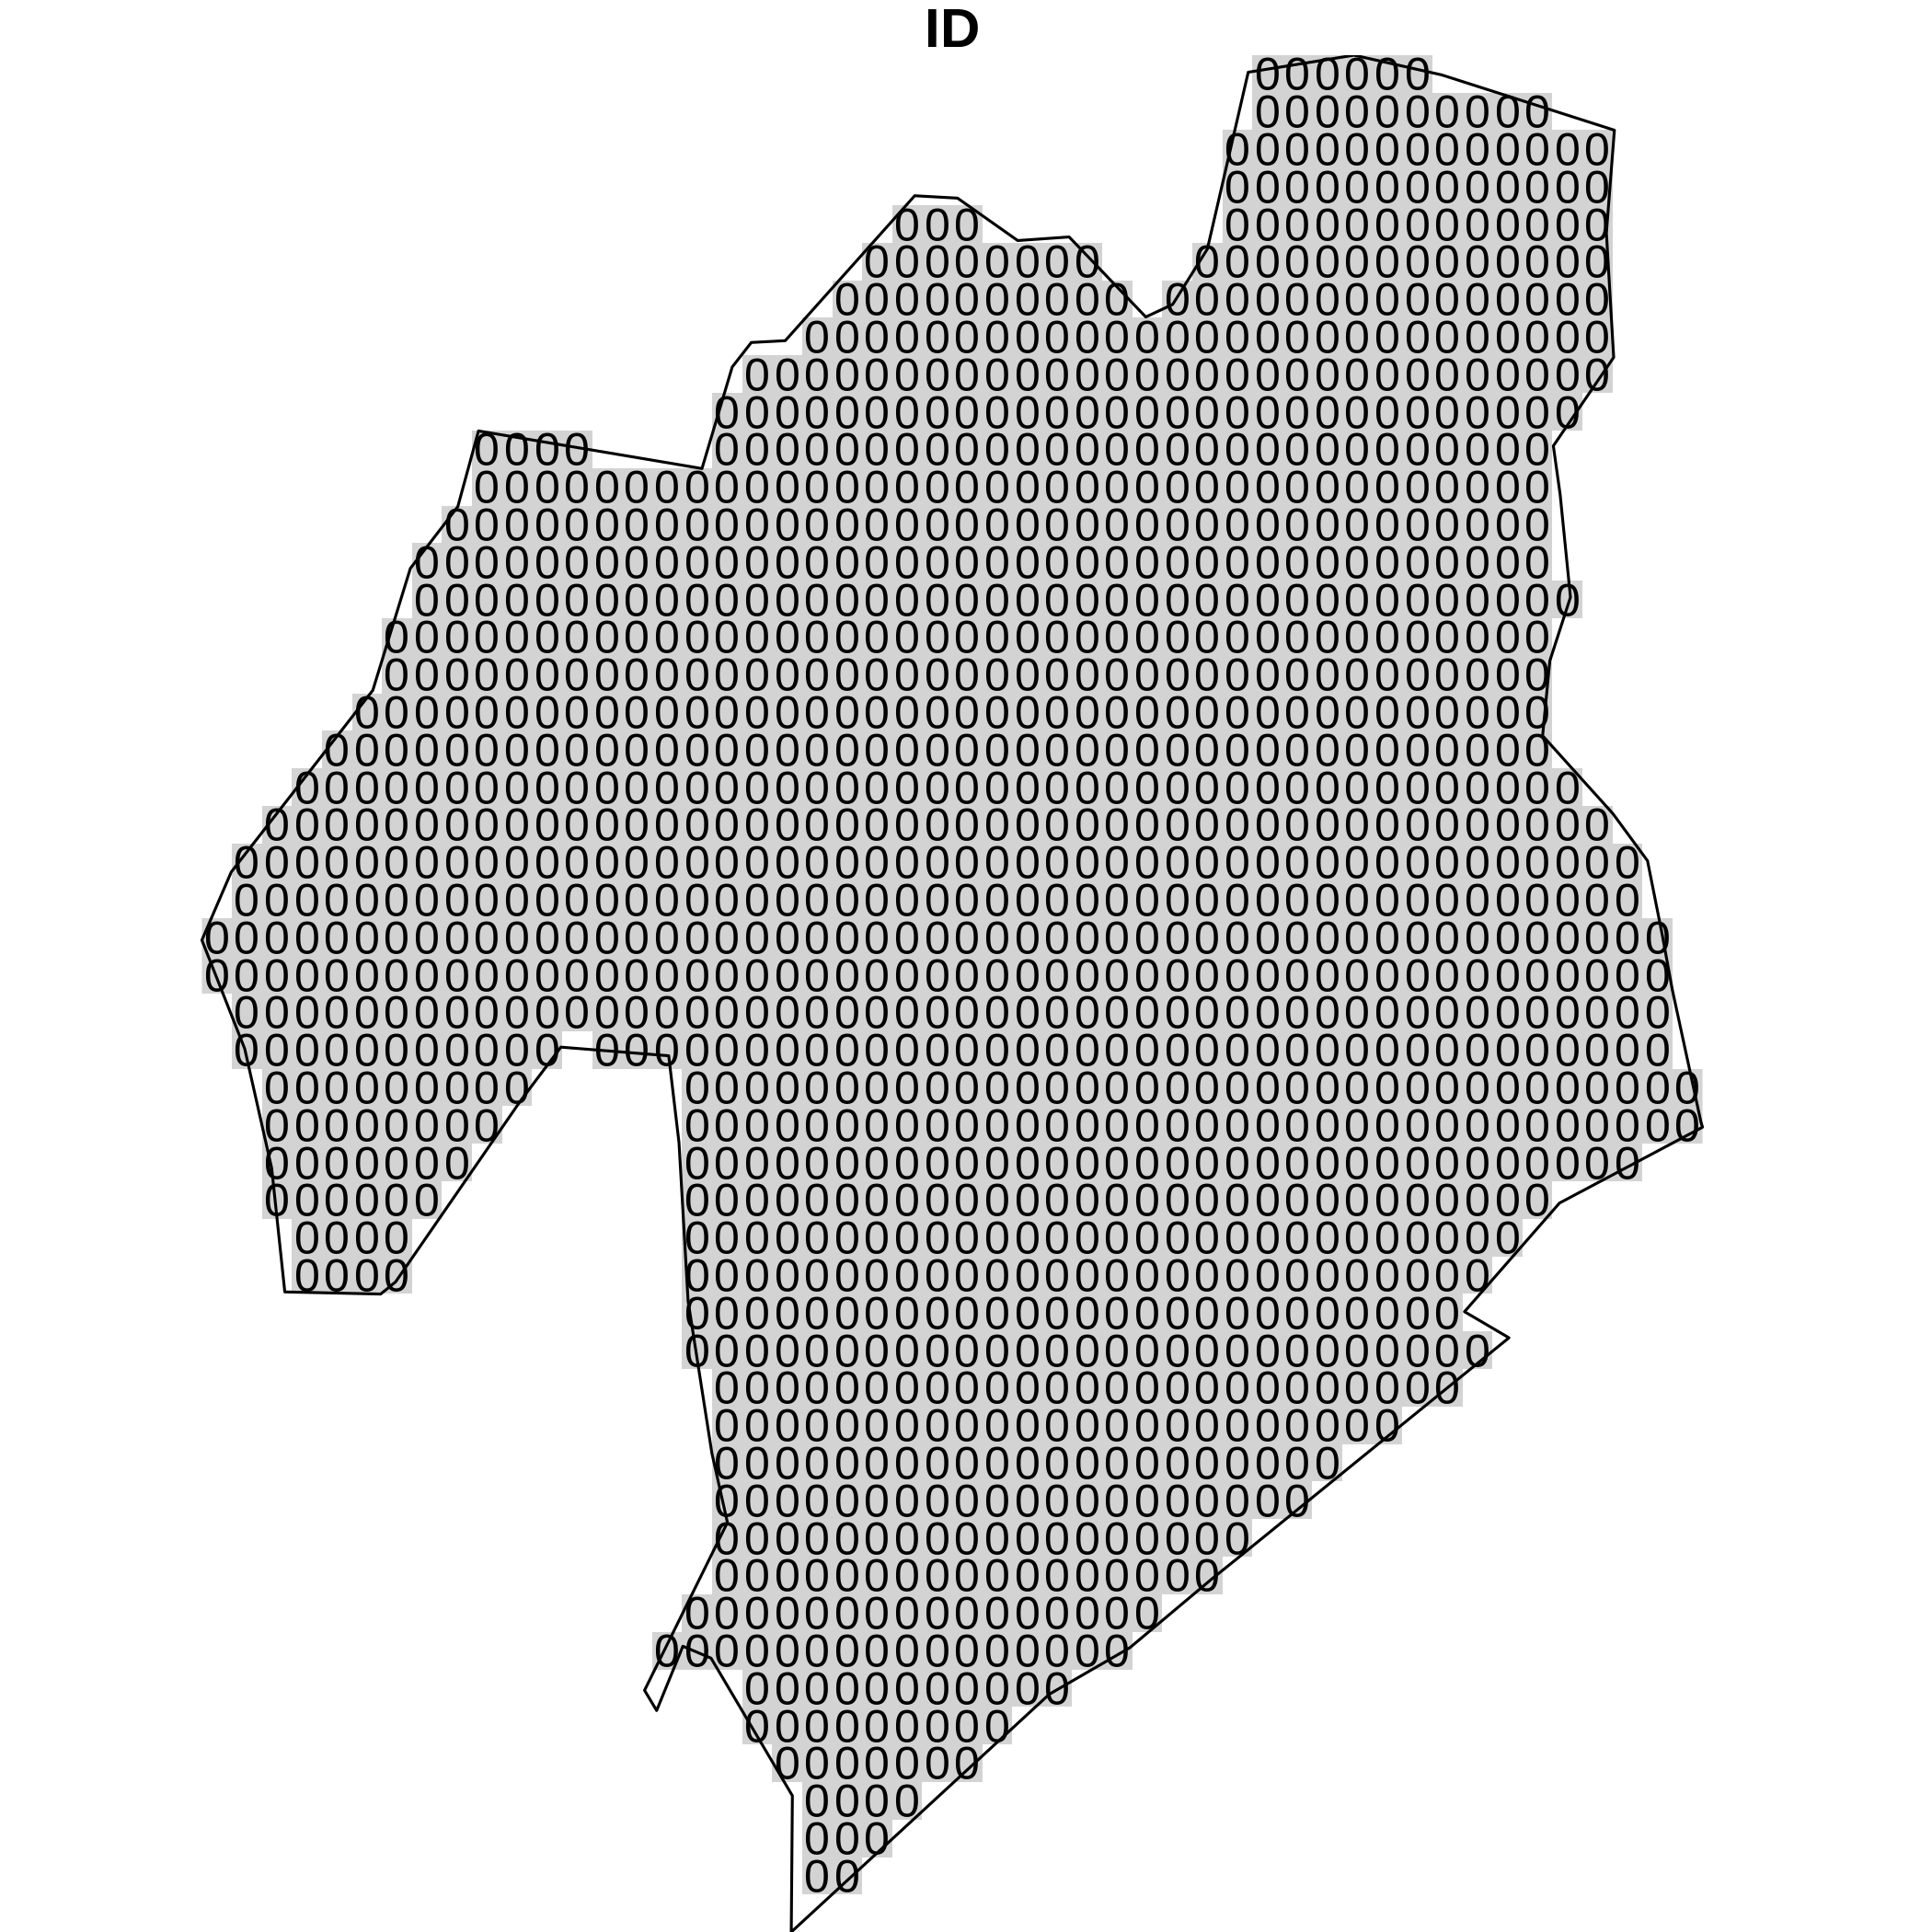

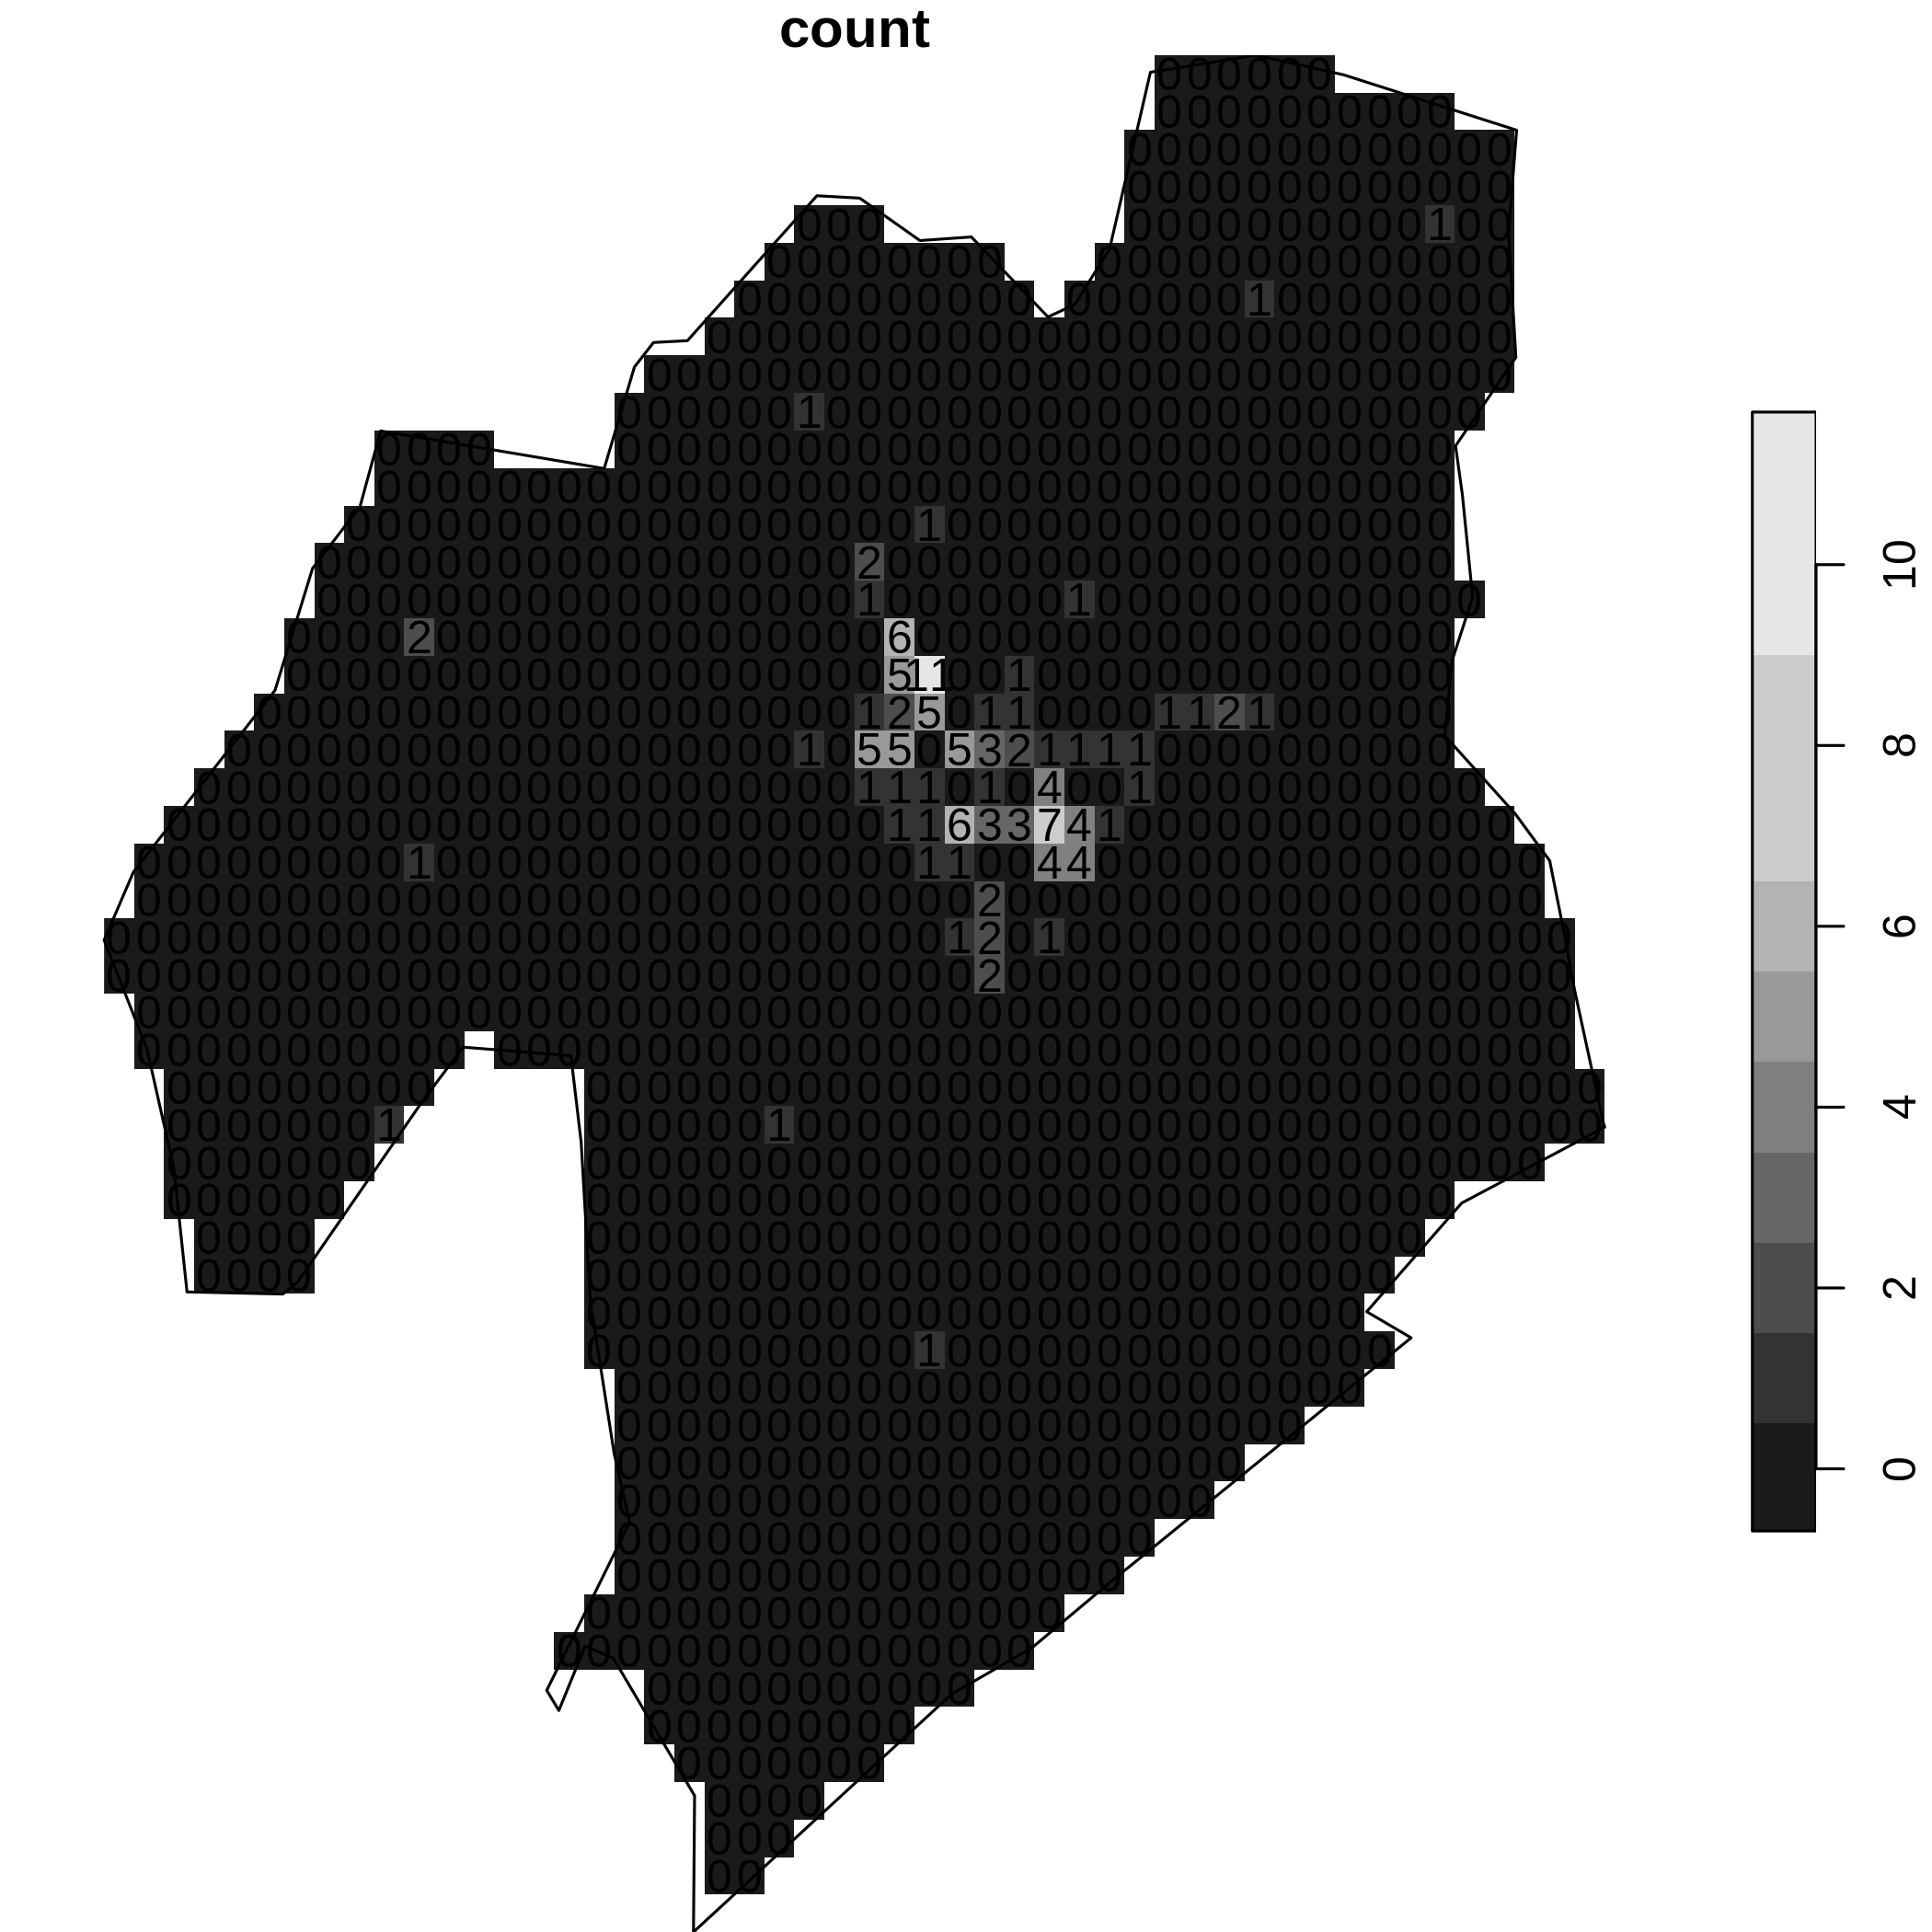

In [15]:
plot(st_geometry(leiden))
plot(st_geometry(locations_leiden), add = TRUE, col = "red")

template = st_rasterize(leiden, st_as_stars(st_bbox(leiden), nx = 50, ny = 50, values = NA_real_))
template[[1]][] = 0
template = template[leiden]
plot(template, text_values = TRUE, breaks = "equal", col = "lightgrey", reset = FALSE)
plot(st_geometry(leiden), add = TRUE)

locations_leiden$count = 1
s = st_rasterize(locations_leiden[, "count"], template, options = "MERGE_ALG=ADD")
plot(s, text_values = TRUE, breaks = "equal", reset = FALSE) #col = grey.colors(12, start = 0.6, rev = TRUE)
plot(st_geometry(leiden), add = TRUE)

# Leiden restaurants proximity (closeness)

In [16]:
# triangulation - subdivision of region into not overlaping triangles
library(spdep)
coords <- locations_leiden %>% select(geometry) %>% distinct() %>% 
  st_geometry() %>% st_centroid(of_largest_polygon = TRUE) 
nb_tri <- coords %>% tri2nb()

Loading required package: sp

Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`



In [17]:
nb_tri %>% 
    nbdists(coords) %>% 
    unlist() %>% 
    summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  13.25   84.14  145.61  323.93  267.63 2736.18 

In [18]:
nb_soi <- nb_tri %>%
    soi.graph(coords) %>% 
    graph2nb()

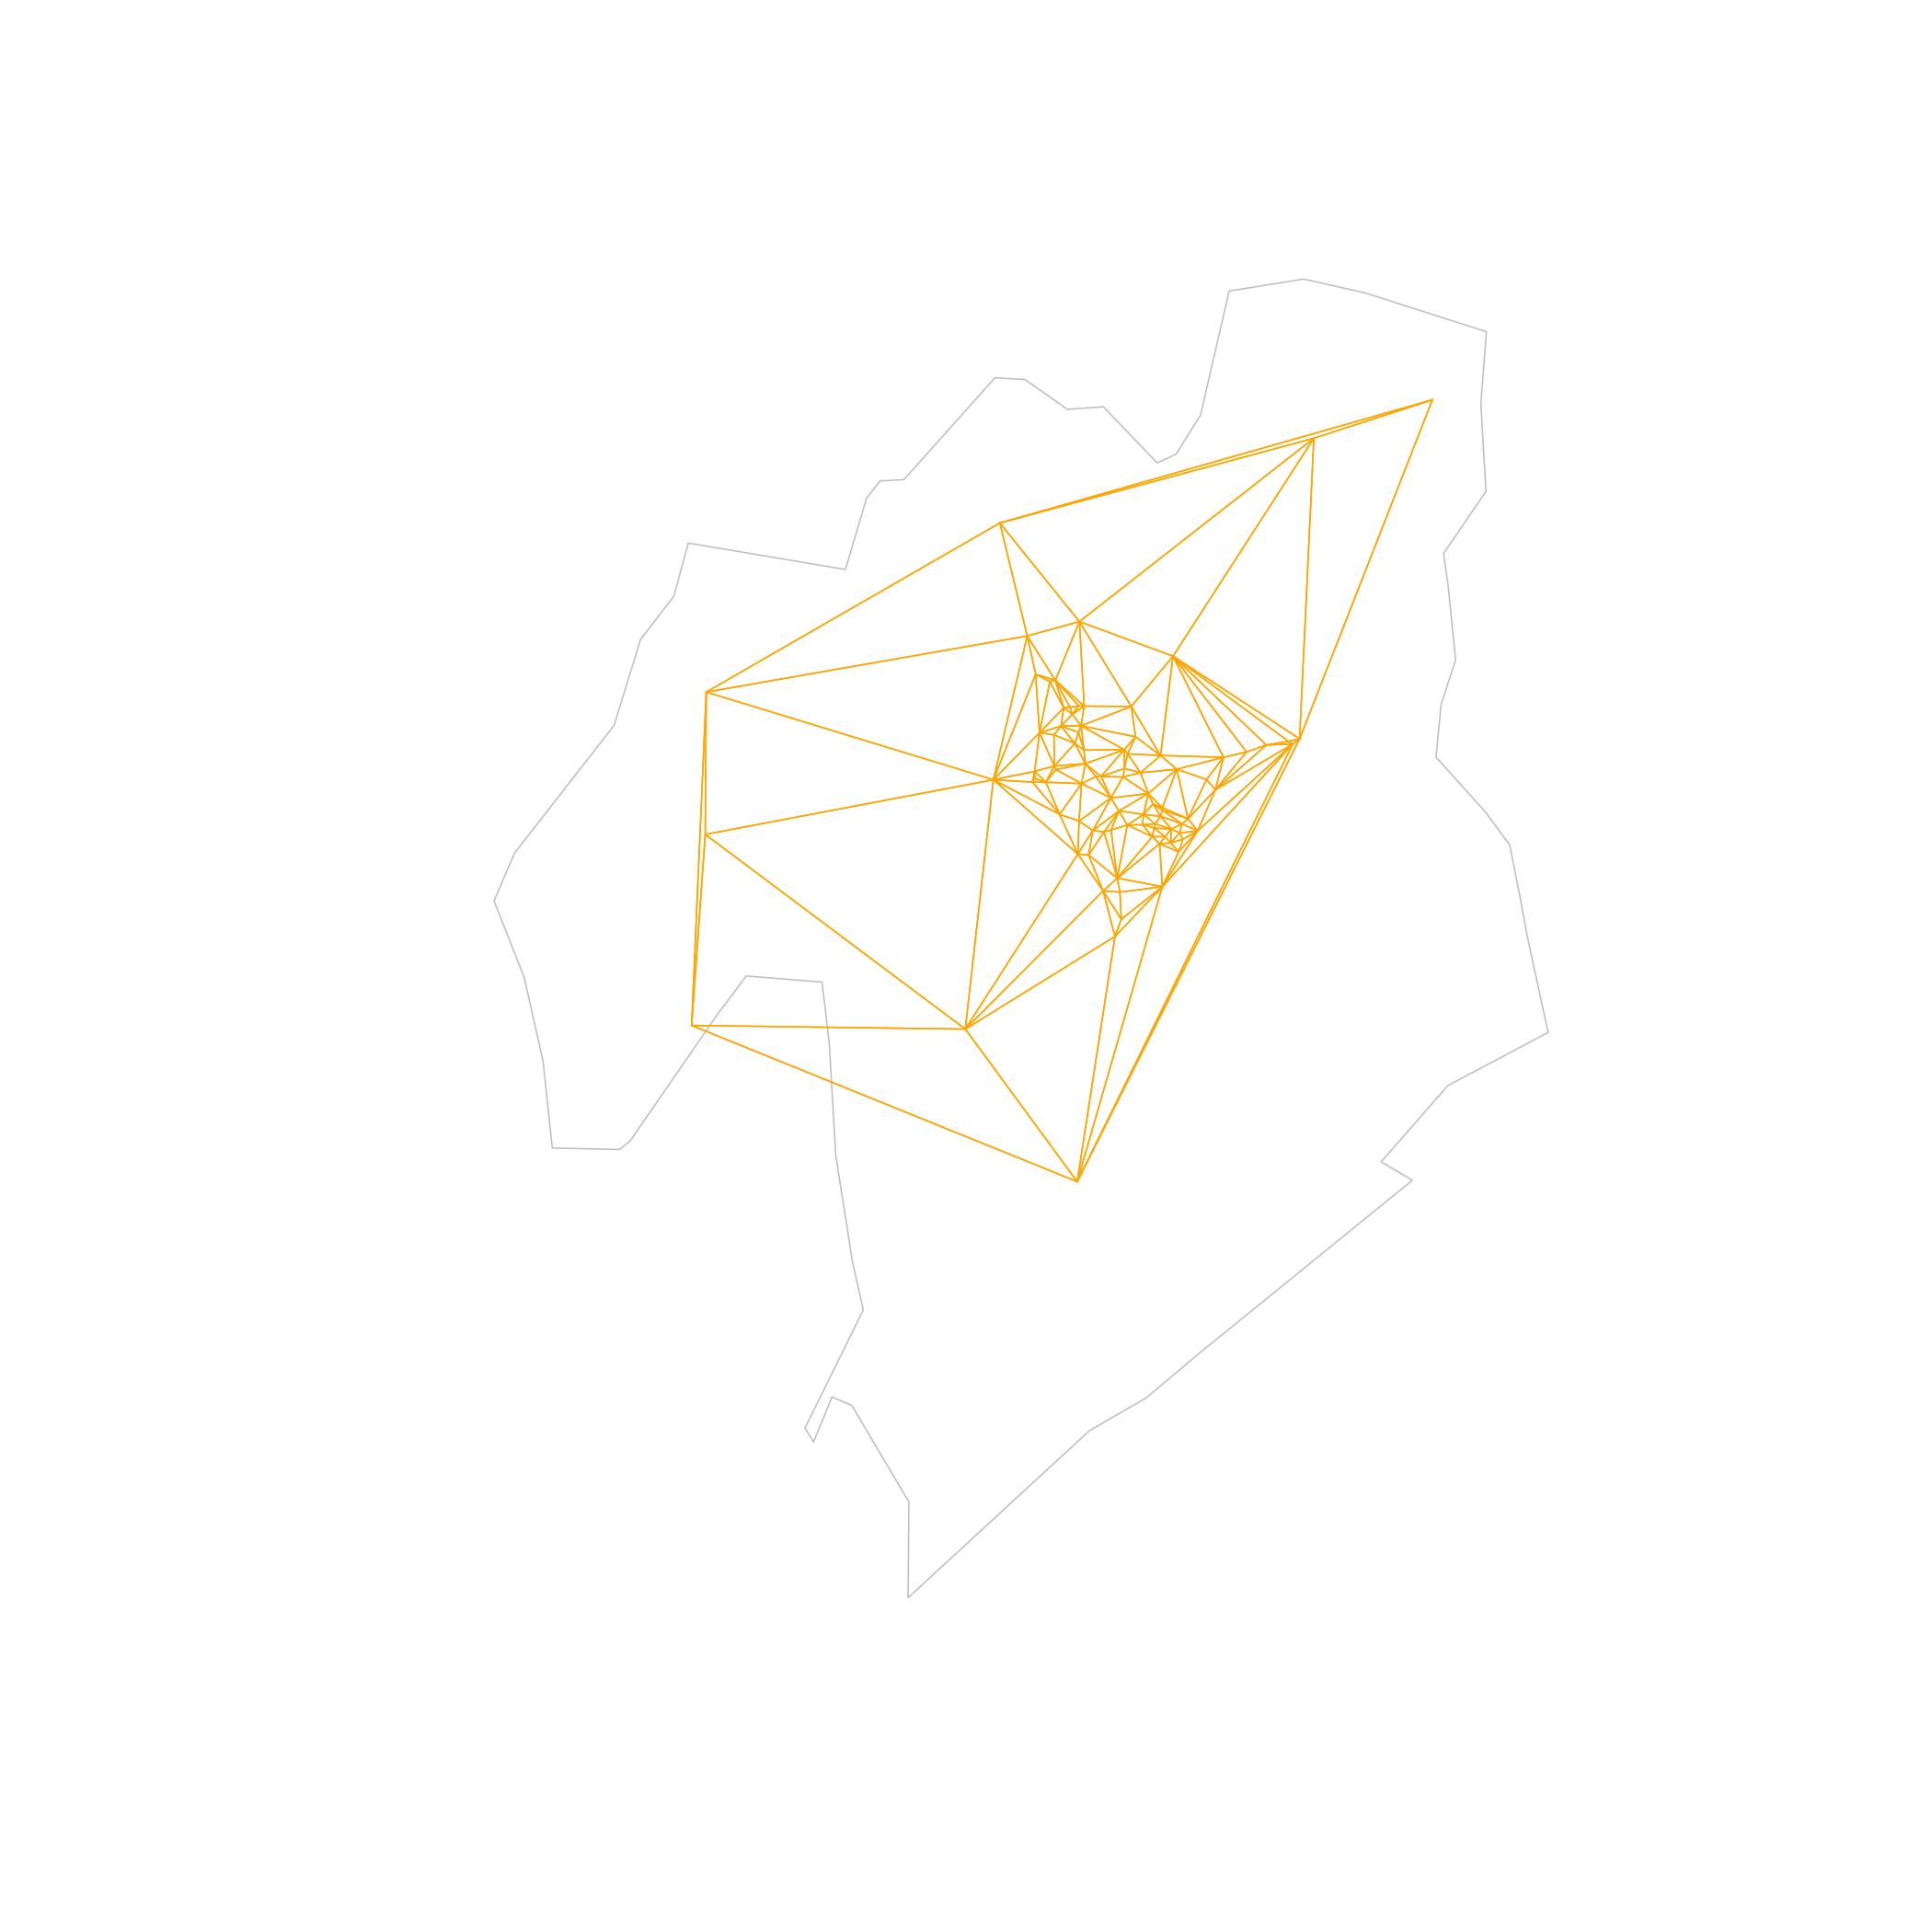

In [19]:
#opar <- par(mar = c(0,0,0,0)+0.5)
leiden %>% 
    st_geometry() %>% 
    plot(border = "grey", lwd = 0.5)
#nb_soi %>% 
#    plot(coords = coords, add = TRUE, points = FALSE, lwd = 0.5)
nb_tri %>% 
#    diffnb(nb_soi) %>% 
    plot(coords = coords, col = "orange", add = TRUE, points = FALSE, lwd = 0.5)

# References:

http://132.72.155.230:3838/r/combining-rasters-and-vector-layers.html

https://keen-swartz-3146c4.netlify.app/